<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/Amazon_Employee_Access_Challenge_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
# 7th August, 2023

# Data Source: Kaggle
# https://www.kaggle.com/datasets/lucamassaron/amazon-employee-access-challenge


A. We keep 'resource' aside while transforming features
   Still get comparable results to xgboost
   on full data with 'resource'

B. Minority class is denoted as 1 and majority class is denoted as 0
   That is, we have changes the class symbols

"""

In [1]:
# -1.0 Mount gdrive:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
## -1.1 Clean up


! rm -r -f /content/allmodels
! rm -r -r /content/datafiles
! rm -r -f /content/transformer.pkl



rm: cannot remove '/content/datafiles': No such file or directory


In [ ]:
# -1.2 D gdrive DATA WILL GET DELETED

!rm -r -f /gdrive/MyDrive/Colab_data_files/amazonrevemp

## Basics
Install software and call libraries

In [3]:
# 0.0 Latest package:

!pip install catencfamily==0.0.89

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.0 MB/s eta 0:00:00


In [4]:
# 0.1 For hyper-parameter tuning:

!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


In [5]:
# 0.2

! pip install python-tabulate

ERROR: Could not find a version that satisfies the requirement python-tabulate (from versions: none)
ERROR: No matching distribution found for python-tabulate


In [32]:
# 1.0 Call libraries
import pandas as pd
import numpy as np

# 1.0.1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import  TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report,f1_score,roc_auc_score
from sklearn.metrics import roc_auc_score

# 1.0.2
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import networkx as nx
from networkx import community

# 1.0.3
import xgboost as xgb
import optuna
import imblearn
from imblearn.over_sampling import SMOTE

# 1.0.4
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.0.5
from tabulate import tabulate
import shutil
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

In [7]:
# 1.0.6 Display multiple commands output from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [8]:
# 1.0.7 Decide program-wide random state:

rng= np.random.RandomState(0)

In [9]:
# Some constants:
amazonfolder  = Path("/gdrive/MyDrive/Colab_data_files/amazonrevemp/")

amazongraphs           = amazonfolder / "models"
amazondata             = amazonfolder / "datafiles"
amazonestimators       = amazonfolder / "estimators"
amazonunitvecs         = amazonfolder / "unitvec"



## Read data
Read and pop-out unwanted features

In [ ]:
# 2.0 Read Data:

url_tr = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/train.csv"
url_te = "https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/amazon/test.csv"
train = pd.read_csv(url_tr)
test = pd.read_csv(url_te)   # Does not contain action columns

In [ ]:
# 2.0.1
train.head(3)
test.head(3)


,action,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880


,id,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
0,1,78766,72734,118079,118080,117878,117879,118177,19721,117880
1,2,40644,4378,117961,118327,118507,118863,122008,118398,118865
2,3,75443,2395,117961,118300,119488,118172,301534,249618,118175


In [ ]:
# 2.0.2
train.shape     # (32769, 10)
test.shape      # (58921, 10)
train.columns

(32769, 10)

(58921, 10)

Index(['action', 'resource', 'mgrid', 'rolerollupOne', 'rolerolluptwo',
       'roledeptname', 'roletitle', 'rolefamilydesc', 'rolefamily',
       'rolecode'],
      dtype='object')

In [ ]:
# 2.0.3
y = train.pop("action")
_= test.pop("id")


In [ ]:
# 2.0.4 Is data balanced? No.
print(y.value_counts())
print(y.value_counts(normalize = True))  # 94%:6%


1    30872
0     1897
Name: action, dtype: int64
1    0.94211
0    0.05789
Name: action, dtype: float64


In [ ]:
# 2.0.5 Let us denote minority class as 1 and majority as 0:
#       Assume minority class is important.
#       This is as per the common convention.

y = 1-y

In [ ]:
# 2.0.6 Check nulls. None.

train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [ ]:
# 2.0.7 Check again:

print(y.value_counts())
print(y.value_counts(normalize = True))  # 94%:6%


0    30872
1     1897
Name: action, dtype: int64
0    0.94211
1    0.05789
Name: action, dtype: float64


## Partition data
`X_train/X_test`

In [ ]:
## 3.0 Split data:

X_train, X_test, y_train,y_test = train_test_split(train,
                                                   y,
                                                   test_size=0.25,
                                                   stratify=y,
                                                   random_state=rng)

In [ ]:
# 3.0.1

X_train.shape  #  (24576, 9)
X_test.shape   #  (8193, 9)
y_train.shape  # (24576,)
y_test.shape   # (8193,)



(24576, 9)

(8193, 9)

(24576,)

(8193,)

In [ ]:
# 3.0.2

X_train.head(2)
X_test.head(2)

,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


In [ ]:
# 3.1 No of unique values in columns:

u = []
for i in train.columns:
  u.append([i, train[i].nunique()])

# 3.1.1
print(tabulate(u, headers = ["col name", "No of unique values"]))

col name          No of unique values
--------------  ---------------------
resource                         7518
mgrid                            4243
rolerollupOne                     128
rolerolluptwo                     177
roledeptname                      449
roletitle                         343
rolefamilydesc                   2358
rolefamily                         67
rolecode                          343


## Instantiate `CatEncodersFamily` class and fit on X_train
Instantiate `CatEncodersFamily` class and fit it on `X_train`

In [ ]:
# 4.0 Which are our cat columns?
#     We will consider for transformation
#     all columns but 'resource'

cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

len(cat_cols)  # 8. 'resource' is not included

# 4.0.1 Keep interacting columns an empty list:

interactingCatCols = []


8

In [ ]:
# 4.1 Instantiate CatEncodersFamily class. We will also save
#     graphs created in a folder:
#     Folder  /content/allmodels/models gets created automatically
#     to deposit cat encoder models and graph related files

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,0,None,1,1],
                       saveGraph = True,
                       k = 40
                       )

# 4.2 Fit it using only X_train.
#     While fitting, 'target' is not needed.
#     Takes time...

ct.fit(X_train,
       cat_cols,
       interactingCatCols
       )

Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('mgrid', 'rolerollupOne', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('mgrid', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolerolluptwo', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roledeptname', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'roletitle', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamilydesc', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolefamily', [1, 1, 1, 0, None, 1, 1]), ('rolerollupOne', 'rolecode', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'mgrid', [1, 1, 1, 0, None, 1, 1]), ('rolerolluptwo', 'rolerollu

CatEncodersFamily(k=40, modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation:
Transform `X_train` and `X_test` using fitted `CatEncodersFamily` object

In [ ]:
# 5.0 Transform both X_test and X_train data:

test_trans = ct.transform(X_test[cat_cols])

f"Transformed test data shape: {test_trans.shape}"  #  (8193, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 14.354136 MB
Mem usage after dtype transformation is: 7.472016 MB


'Transformed test data shape: (8193, 218)'

In [ ]:
# 5.0.1 Transform X_train now:

train_trans= ct.transform(X_train[cat_cols])

f"Transformed train data shape: {train_trans.shape}" # Transformed train data shape: (24576, 218)



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  224
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 43.057152 MB
Mem usage after dtype transformation is: 22.413312 MB


'Transformed train data shape: (24576, 218)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 5.2 Observe data now:
#     It also has original binned cols (6):

train_trans.head(3)
test_trans.head(3)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,0.212401,0.009444,0.016670,0.029940,3.125120e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.004639,0.060084,0.023952,0.010817,0.004082,0.006943,0.005988,-2.292850e-17,0.003087
2,14952,117961,117962,119223,119962,168365,118205,119964,0.421883,0.024354,...,0.006909,0.005927,0.018370,0.056886,0.191159,0.006110,0.000316,0.011976,-2.078231e-17,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002170,0.033180,0.005988,5.756833e-18,0.003894,0.000000,0.008982,-1.122321e-17,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,2.124007e-01,0.009444,0.016670,0.029940,3.125120e-17,0.003087
2,21135,117961,118343,123494,118784,121926,290919,118786,0.421883,0.024354,...,0.011398,0.036483,0.061985,0.092814,2.272589e-01,0.010813,0.011673,0.029940,3.012902e-17,0.003087


In [ ]:
# 5.3
train_trans.shape   #   (24576, 218)
test_trans.shape    #  (8193, 218)

(24576, 218)

(8193, 218)

In [ ]:
# 5.4 Save ct to current folder:
utils.savePythonObject(ct, "transformer.pkl")

Object saved to: /content/transformer.pkl


## Make an archive of files in gdrive
Save `X_train/X_test`, `CatEncodersFamily` object and transformed data to your gdrive for subsequent use


In [ ]:
# 6.1 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Archive of graph files to gdrive

In [ ]:
# 6.2 Archive folder where graph files are stored to gdrive
#     This will also create the folder amazonfolder

dir_to_be_archived = "/content/allmodels/models/"

shutil.make_archive(str(amazongraphs), 'zip', dir_to_be_archived )

'/gdrive/MyDrive/Colab_data_files/amazonrevemp/models.zip'

In [ ]:
# 6.3 unpack the zipped file at gdrive now:
#     This will also create the folder amazongraphs:

shutil.unpack_archive(str(amazongraphs) +".zip", amazongraphs, 'zip')

In [ ]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = amazongraphs.glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]
print("\n=====\n")
print("Total graph files: ", len(files))

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/rolecode_bigraph_mgrid.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/roletitle_bigraph_rolerolluptwo.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_projected_rolefamilydesc.gml')]


=====

Total graph files:  112


### Archive of datafiles

#### Save first to local destination

In [ ]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)


# 6.5.1 Full file paths:
#       Our train/test data
trfile = destination / "X_train.pkl"
tefile = destination / "X_test.pkl"
ytr = destination / "y_train.pkl"
yte = destination / 'y_test.pkl'

# 6.5.2 Our transformed data
trtrans = destination / 'train_trans.pkl'
tetrans = destination / 'test_trans.pkl'


# 6.5.3 Now save
X_train.to_pickle(trfile)
X_test.to_pickle(tefile)
y_train.to_pickle(ytr)
y_test.to_pickle(yte)
train_trans.to_pickle(trtrans)
test_trans.to_pickle(tetrans)

#### Transfer from local to gdrive

In [ ]:
# 6.6 Archive folder where pickle files are stored to gdrive

dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(str(amazondata), 'zip', dir_to_be_archived )



'/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles.zip'

In [ ]:
# 6.6.1 Unpack the zipped file now:
shutil.unpack_archive(str(amazondata)+".zip", amazondata, 'zip')

### Archive of transformer object

In [ ]:
# 6.7 Also copy 'transformer.pkl' to gdrive

shutil.copy('/content/transformer.pkl', str(amazondata) +"/"+  'transformer.pkl')


'/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/transformer.pkl'

### Our data files on gdrive

In [ ]:
# 6.8 Let us have a look at our list of pickled data files:

p = amazondata.glob('**/*')
files = [x for x in p if x.is_file()]
files
print("\n=====\n")
print(len(files))  # 7

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/y_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/X_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/test_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/train_trans.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/y_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/X_test.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/transformer.pkl')]


=====

7


## Read back archived datafiles
Read back saved objects and data files from gdrive archive

In [13]:
# 7.0
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [14]:
# 7.1

X_train = pd.read_pickle(amazondata / "X_train.pkl")
X_test = pd.read_pickle(amazondata / "X_test.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

train_trans = pd.read_pickle(amazondata / "train_trans.pkl")
test_trans = pd.read_pickle(amazondata / "test_trans.pkl")
ct = pd.read_pickle(amazondata / "transformer.pkl")

In [15]:
# 7.0.1 Check
train_trans.shape  # (24576, 218)
test_trans.shape  # (8193, 218)

# 7.0.2 Target is not present in the data:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)

(24576, 218)

(8193, 218)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,0.212401,0.009444,0.016670,0.029940,3.125120e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.004639,0.060084,0.023952,0.010817,0.004082,0.006943,0.005988,-2.292850e-17,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002170,0.033180,0.005988,5.756833e-18,0.003894,0.00000,0.008982,-1.122321e-17,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,2.124007e-01,0.009444,0.01667,0.029940,3.125120e-17,0.003087


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


In [16]:
# 7.0.3
cat_cols = [ 'mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']
len(cat_cols)  # 8

8

## xgboost modeling of original data and of transformed data:

### Original data first

In [ ]:
# 8.0 Original train/test data:
# Includes 'resource'

model_orig = xgb.XGBClassifier( n_estimators= 200,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,           # 0.8
                                random_state = rng,
                                reg_lambda = 1.5,
                            )


tr_X =   X_train
test_X = X_test
ytr = y_train
yte = y_test


model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 50,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


[09:11:06] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:11:06] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.66063	validation_1-auc:0.63740
[09:11:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.66206	validation_1-auc:0.63887
[09:11:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.69849	validation_1-auc:0.66486
[09:11:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.69967	validation_1-auc:0.67009
[09:11:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.74881	validation_1-auc:0.71331
[09:11:07] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 312 extra nodes, 0 pruned n

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7884437004c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 160, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[13]	validation_0-auc:0.86323	validation_1-auc:0.78514
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=15
[14]	validation_0-auc:0.87737	validation_1-auc:0.78900
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=15
[15]	validation_0-auc:0.88510	validation_1-auc:0.79594
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=15
[16]	validation_0-auc:0.88791	validation_1-auc:0.79592
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=15
[17]	validation_0-auc:0.89417	validation_1-auc:0.79755
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 596 extra nodes, 0 pruned nodes, max_depth=15
[18]	validation_0-auc:0.90009	validation_1-auc:0.80168
[09:11:08] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 622 extra nodes, 0 pruned nodes,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 8.0.1 Save models to amazonestimators folder:
amazonestimators.mkdir(parents=True, exist_ok=True)

# 8.0.2 Save estimator: model_orig
utils.savePythonObject(model_orig, "model_orig.pkl", amazonestimators )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/estimators/model_orig.pkl


In [ ]:
# 8.0.3 Read back saved estimator:
model_orig = utils.restorePythonObject("model_orig.pkl", amazonestimators )

In [ ]:
# 8.1 Our scores:

f"Best auc from orig train/test data: {model_orig.best_score}"    #  0.8414939190544/0.8414939190544675
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"   # 157/157

'Best auc from orig train/test data: 0.8414939190544675'

'Best iteration from orig train/test data: 157'

### Transformed data next

In [ ]:
# 9.0 Modeling with transformed data

model_trans = xgb.XGBClassifier( n_estimators= 250,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,
                                random_state = rng,
                                reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =  train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_train
ytest = y_test


model_trans.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )

[09:14:50] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:14:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.77600	validation_1-auc:0.73164
[09:14:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.79215	validation_1-auc:0.75072
[09:14:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.81322	validation_1-auc:0.77006
[09:14:53] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.82904	validation_1-auc:0.77275
[09:14:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 396 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.84395	validation_1-auc:0.78323
[09:14:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 388 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 9.0.1 Save estimator: model_trans
utils.savePythonObject(model_trans, "model_trans.pkl", amazonestimators )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/estimators/model_trans.pkl


In [ ]:
# 9.0.2 Read back saved estimator:
model_trans = utils.restorePythonObject("model_trans.pkl", amazonestimators )

In [ ]:
# 9.0.3
f"Best auc from transformed train/test data: {model_trans.best_score}"   # 0.8498455507/ 0.854875606960/0.8512462808
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"  # 106/114/131

'Best auc from transformed train/test data: 0.8523589389544021'

'Best iteration from transformed train/test data: 107'

### Learning curve plots
Learning curves for both original and transformed data

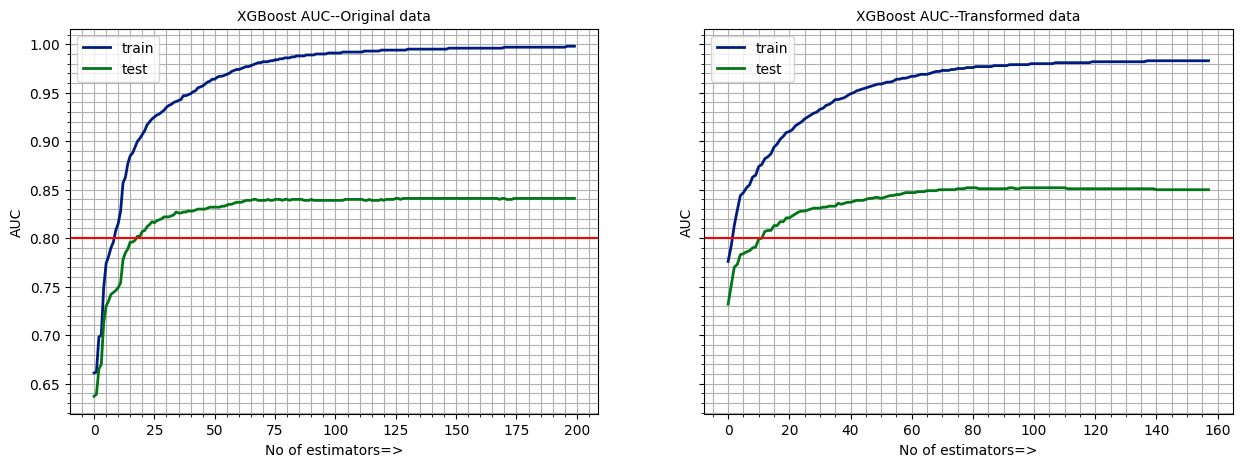

In [ ]:
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data']

for i in range(2):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

### Classification reports

In [ ]:
# 9.4
pred_orig = model_orig.predict(X_test)
pred_trans = model_trans.predict(test_X)

print("Note that the f1-score from transformed data is better than that from original data\n")
print(f"Classification report from original data: \n {classification_report(ytest,pred_orig)}")
print("\n==================\n")
print(f"Classification report from transformed data: \n {classification_report(ytest,pred_trans)}")



Note that the f1-score from transformed data is better than that from original data

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from transformed data: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      7719
           1       0.66      0.37      0.47       474

    accuracy                           0.95      8193
   macro avg       0.81      0.68      0.72      8193
weighted avg       0.94      0.95      0.95      8193



## PCAs with transformed data:
This is essentially to see how data looks in 2D

In [ ]:
# 10.0 Check if any nulls in data
#       else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16000
pca_train = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

16000

In [ ]:
# 10.1 Impute. as test data has null values:

si = SimpleImputer(strategy = 'median')
pca_train[:] = si.fit_transform(pca_train)
pca_test[:] = si.transform(pca_test)

In [ ]:
# 10.2 2D PCA with transformed train data.
#      Drop the initial cat_cols first:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
pca_train = pca.fit_transform(ss.fit_transform(pca_train))
pca_test = pca.transform(ss.transform(pca_test))

In [ ]:
# 10.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train.shape[1])]
pca_train = pd.DataFrame(pca_train, columns = colnames)
pca_test = pd.DataFrame(pca_test, columns = colnames)

In [ ]:
# 10.3.1 Save PCA data:
pca_train.to_pickle(amazondata / "pca_train.pkl")
pca_test.to_pickle(amazondata / "pca_test.pkl")

In [ ]:
# 10.3.2 Read back PCA data:
pca_train = pd.read_pickle(amazondata / "pca_train.pkl")
pca_test = pd.read_pickle(amazondata / "pca_test.pkl")

# Check
pca_train.shape   # (24576, 2)
pca_test.shape    # (8193, 2)
pca_train.head(2)
pca_test.head(2)


(24576, 2)

(8193, 2)

,pc0,pc1
0,-1.173291,0.941378
1,0.424248,-1.447813


,pc0,pc1
0,0.231978,-1.373387
1,-1.205328,0.910767


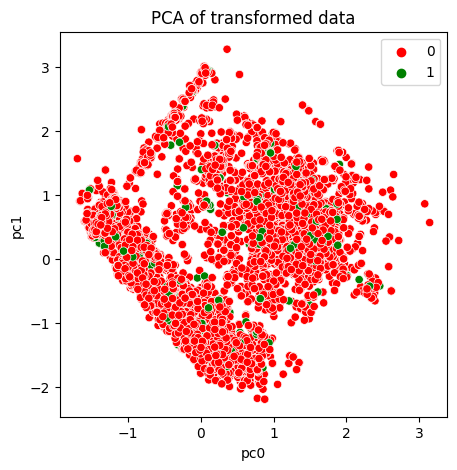

In [ ]:
# 10.4 2D PCA plot from original train data:
plt.style.use('seaborn-v0_8-dark-palette')
fig = plt.figure(figsize = (5,5));
fig.add_subplot(1,1,1);
sns.scatterplot(data = pca_train,
                x= 'pc0',
                y = 'pc1',
                hue = y_train.values,
                palette = ["red", "green"]
                ).set(title='PCA of transformed data') ;



## How good is 2-components PCA?
We perform predictive analytics with the 2-components PCA

In [ ]:
# 11.0
model_pca = xgb.XGBClassifier( n_estimators= 1000,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 15,
                              subsample = 0.8,
                              random_state = rng
                           )


tr_X = pca_train
test_X = pca_test
ytrain = y_train
ytest = y_test


model_pca.fit(tr_X, ytrain.values,
          early_stopping_rounds = 100,   # 10% of n_estimators
          eval_set=[ (tr_X, ytrain.values), (test_X, ytest.values)],
          eval_metric = ['auc']    # binary classification problem
          )

# We need test_X for future
# So copy it:
test_X_pca =test_X.copy()


[09:19:23] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:19:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation_0-auc:0.58981	validation_1-auc:0.59880
[09:19:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 34 extra nodes, 0 pruned nodes, max_depth=12
[1]	validation_0-auc:0.61499	validation_1-auc:0.61722
[09:19:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.62817	validation_1-auc:0.62324
[09:19:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.67569	validation_1-auc:0.65696
[09:19:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.69852	validation_1-auc:0.67971
[09:19:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 176 extra nodes, 0 pruned nodes

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 11.0.1 Save estimator: model_trans
utils.savePythonObject(model_pca, "model_pca.pkl", amazondata )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/model_pca.pkl


In [ ]:
# 11.0.2 Read back saved estimator:
model_pca = utils.restorePythonObject("model_pca.pkl", amazondata )

### Learning plots

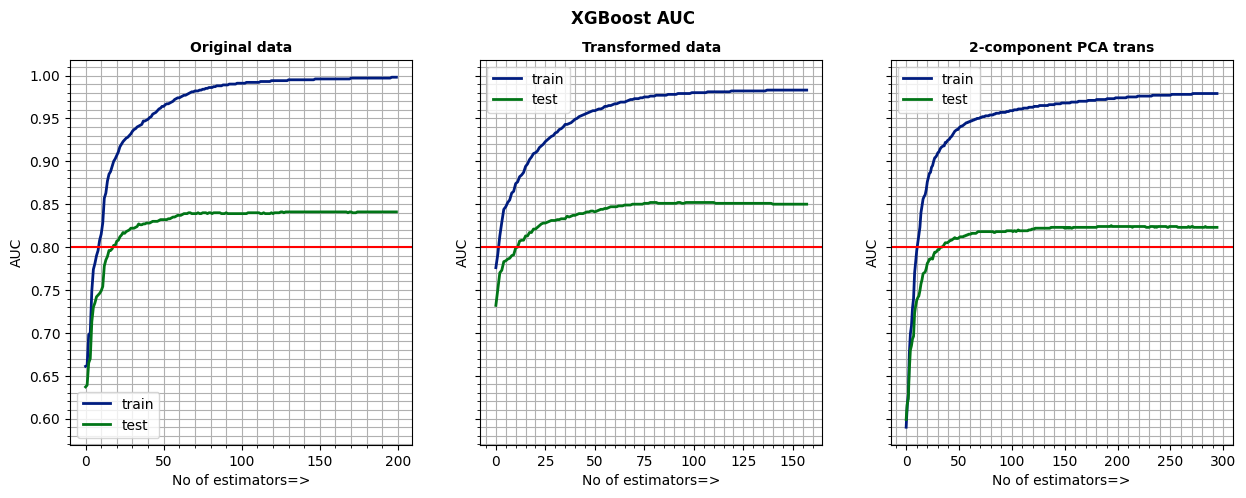

In [45]:
# 11.1
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,3, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_pca.evals_result() ]
title = ["Original data", 'Transformed data', '2-component PCA trans']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(3):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

### Classification reports 2-components PCA

In [ ]:
# 11.3 Classification reports:

pred_orig = model_orig.predict(X_test)
pred_pca = model_pca.predict(pca_test)

print("Note that the difference in the two classification reports exist but not to great extent\n")
print(f"Classification report from original data: \n {classification_report(y_test,pred_orig)}")
print("\n==================\n")
print(f"Classification report from PCA data: \n {classification_report(y_test,pred_pca)}")



Note that the difference in the two classification reports exist but not to great extent

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from PCA data: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.65      0.30      0.41       474

    accuracy                           0.95      8193
   macro avg       0.80      0.64      0.69      8193
weighted avg       0.94      0.95      0.94      8193



## tsne
Takes time..Does this plot show any pattern?

In [ ]:
# 12.0 Instantiate class:
tsne = TSNE(perplexity = 30)  # perplexity of 30 gives best AUC
                              # Tried 20 and 50 also

# 12.0.1 Fit and transform
ss = StandardScaler()
da = tsne.fit_transform(ss.fit_transform(train_trans.iloc[:, len(cat_cols) : ]))

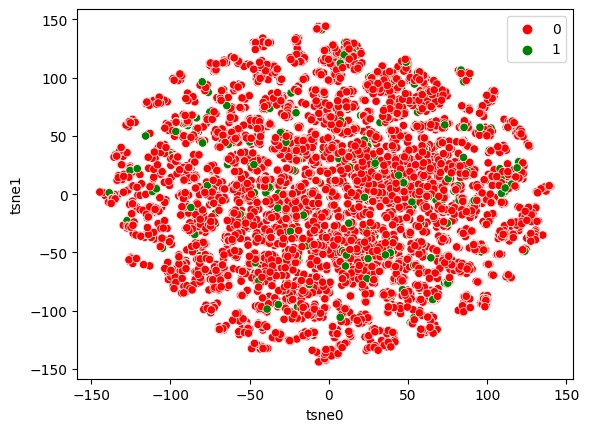

In [ ]:
# 12.1 Plot tsne output:

colnames = ["tsne" + str(i) for i in range(da.shape[1])]
da = pd.DataFrame(da, columns = colnames)
plt.figure(100);
sns.scatterplot(x= da['tsne0'], y = da['tsne1'], hue = y_train.values, palette = ["red", "green"]);

## How good is 2-components tsne data in making predictions?

In [ ]:
# 13.0 tsne class in sklearn does not have a transform method
# We cannot transform our test_trans data using tsne-object
# Let us partition tsne-transformed data itself:

Xtrain, Xtest, ytr, yte = train_test_split(da,
                                           y_train,
                                           test_size = 0.20,
                                           stratify= y_train,
                                           random_state = rng)

model_tsne = xgb.XGBClassifier( n_estimators= 250,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 6,
                           subsample = 0.8,
                           random_state = rng
                           )


tr_X =  Xtrain
test_X = Xtest



model_tsne.fit(tr_X, ytr,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )

[09:25:49] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 26 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.58946	validation_1-auc:0.56292
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 40 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.62509	validation_1-auc:0.59288
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 38 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.64768	validation_1-auc:0.61490
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.65131	validation_1-auc:0.61619
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.65377	validation_1-auc:0.61631
[09:25:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 46 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 13.0.1 Save estimator: model_trans:

utils.savePythonObject(model_tsne, "model_tsne.pkl", amazondata )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/model_tsne.pkl


In [ ]:
# 13.0.2 Read back saved estimator:

model_tsne = utils.restorePythonObject("model_tsne.pkl", amazondata )

### Learning plots

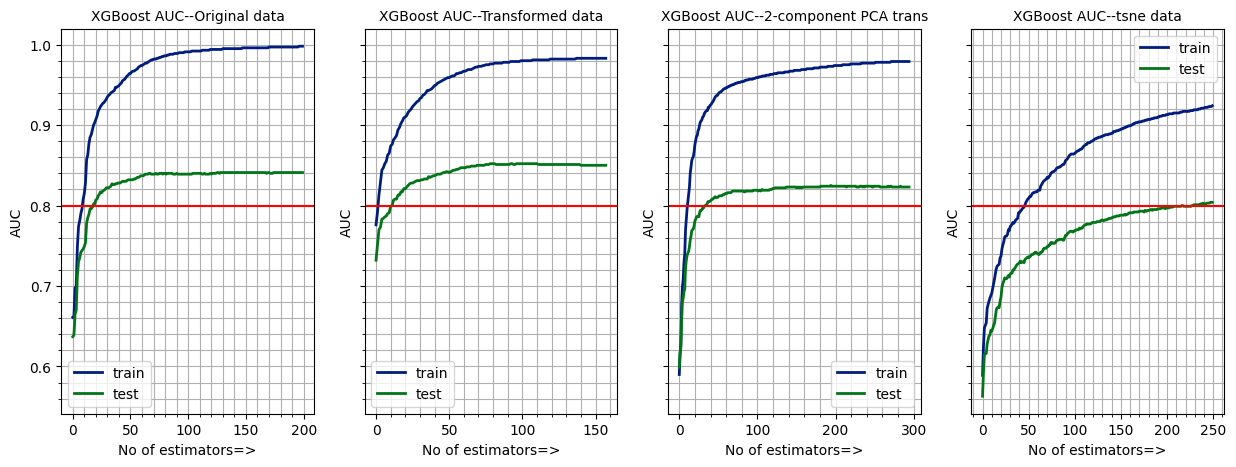

In [ ]:
# 11.1
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,4, figsize = (15,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_pca.evals_result(), model_tsne.evals_result() ]
title = ["XGBoost AUC--Original data", 'XGBoost AUC--Transformed data', 'XGBoost AUC--2-component PCA trans', 'XGBoost AUC--tsne data' ]

for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10);
    ax[i].axhline(y = 0.8, color = 'r', linestyle = '-')

plt.show();

## Hyperparameter tuning--original data
We use optuna and maximize f1-score

In [ ]:
# 14.0
# REf: https://practicaldatascience.co.uk/machine-learning/how-to-use-optuna-for-xgboost-hyperparameter-tuning
# Maximise f1_score.

# Original data
tr_X =  X_train
test_X = X_test
ytrain = y_train
ytest = y_test



# 14.1 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
             }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 14.2 Create optuna study
study = optuna.create_study(direction='maximize')

# 14.3 Begin optimization
study.optimize(objective, n_trials=300)

# Can run this function again to optimize further
#study.optimize(objective, n_trials=200)



[I 2023-08-06 09:28:26,282] A new study created in memory with name: no-name-ee4e9697-5e8e-47d8-8893-006fc760aa45
[I 2023-08-06 09:28:29,914] Trial 0 finished with value: 0.12267657992565054 and parameters: {'max_depth': 3, 'learning_rate': 0.3321643124405141, 'n_estimators': 432, 'min_child_weight': 3, 'gamma': 0.04875338488639768, 'subsample': 0.4415891936250486, 'colsample_bytree': 0.023094241437349085, 'reg_alpha': 7.098583384217201e-08, 'reg_lambda': 1.4818788252658535e-06}. Best is trial 0 with value: 0.12267657992565054.
[I 2023-08-06 09:28:31,537] Trial 1 finished with value: 0.13608748481166463 and parameters: {'max_depth': 2, 'learning_rate': 0.822803981147674, 'n_estimators': 472, 'min_child_weight': 4, 'gamma': 0.02698847338664548, 'subsample': 0.039583293674267724, 'colsample_bytree': 0.02276140148466, 'reg_alpha': 0.08401913880389424, 'reg_lambda': 0.0014664266483335926}. Best is trial 1 with value: 0.13608748481166463.
[I 2023-08-06 09:28:33,137] Trial 2 finished with va

In [ ]:
# 14.4 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 14.4.1 Best trial
trial = study.best_trial
trial.value   # Best trial result (f1-score)
# Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

"""

Number of finished trials: 300

0.45714285714285713

    max_depth: 11
    learning_rate: 0.553336735296104
    n_estimators: 358
    min_child_weight: 5
    gamma: 1.0572155660272875e-06
    subsample: 0.9819637397077845
    colsample_bytree: 0.5445399139409933
    reg_alpha: 1.270314970367875e-05
    reg_lambda: 0.024201716886479412


"""


Number of finished trials: 300


0.4621309370988447

    max_depth: 13
    learning_rate: 0.49283807309526995
    n_estimators: 377
    min_child_weight: 9
    gamma: 0.0005498557391413127
    subsample: 0.8101392187010694
    colsample_bytree: 0.3915464617094827
    reg_alpha: 0.0019372512991674964
    reg_lambda: 6.964121688556502e-07


'\n\nNumber of finished trials: 300\n\n0.45714285714285713\n\n    max_depth: 11\n    learning_rate: 0.553336735296104\n    n_estimators: 358\n    min_child_weight: 5\n    gamma: 1.0572155660272875e-06\n    subsample: 0.9819637397077845\n    colsample_bytree: 0.5445399139409933\n    reg_alpha: 1.270314970367875e-05\n    reg_lambda: 0.024201716886479412\n\n\n'

In [ ]:
# 15.0 Use these parameters in our estimator:
best_params = trial.params

model_ht_orig = xgb.XGBClassifier(**best_params)
model_ht_orig.fit(tr_X, y_train)



In [ ]:
# 15.0.1 Svave estimator:

utils.savePythonObject(model_ht_orig, "model_ht_orig.pkl", amazondata )



Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/model_ht_orig.pkl


In [10]:
# 15.0.2 Read back estimator:

model_ht_orig = utils.restorePythonObject("model_ht_orig.pkl", amazondata)

In [ ]:
# 15.1 Make predictions and assessments:

y_pred_op = model_ht_orig.predict(test_X)

print(classification_report(y_test, y_pred_op))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.59      0.38      0.46       474

    accuracy                           0.95      8193
   macro avg       0.78      0.68      0.72      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
"""
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      7719
           1       0.56      0.39      0.46       474

    accuracy                           0.95      8193
   macro avg       0.76      0.68      0.71      8193
weighted avg       0.94      0.95      0.94      8193

"""

In [18]:
y_test

12953    0
17348    0
7246     1
12476    0
20692    0
        ..
3803     0
8316     0
28418    0
12516    0
9052     0
Name: action, Length: 8193, dtype: int64

In [27]:
g = y_test.values
g

array([0, 0, 1, ..., 0, 0, 0])

In [30]:
 model_ht_orig.predict_proba(X_test)[:,1]

array([1.2969453e-02, 2.7252601e-02, 9.3085217e-01, ..., 1.8686943e-03,
       4.4408921e-04, 4.5412481e-01], dtype=float32)

In [34]:
# 15.1.1 AUC score:

roc_auc_score(y_test.values, model_ht_orig.predict_proba(X_test)[:,1])   # 0.8381701571496276

0.8381701571496276

## Hyperparameter tuning--transformed data + SMOTE

### Generate synthetic data with SMOTE:

In [ ]:
# 16.0
# Train/test data
# Filter out initial cat_cols
# Keep only their numeric
# transformations

tr_X =  train_trans.iloc[:, len(cat_cols):]
test_X = test_trans.iloc[:, len(cat_cols):]
ytrain = y_train
ytest = y_test

# 16.1 Apply SMOTE
sm = SMOTE(random_state=rng)
X_res, y_res = sm.fit_resample(tr_X, ytrain)
X_res.shape  # (46306, 210)

(46306, 210)

### Train/test data after SMOTE

In [ ]:
# 16.2
tr_X = X_res
test_X = test_trans.iloc[:,len(cat_cols):]
ytrain = y_res
ytest = y_test


### Apply optuna for hyperparameter tuning


In [ ]:
# 17.0 Optuna, define objective function
def objective(trial):
    """Define the objective function"""

    # xgboost parameter ranges
    params = {
              'max_depth': trial.suggest_int('max_depth', 1, 14),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
              'n_estimators': trial.suggest_int('n_estimators', 50, 500),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
              'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
              'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
              'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
              'eval_metric': 'auc',
              'use_label_encoder': False
    }


    optuna_model = xgb.XGBClassifier(**params)
    optuna_model.fit(tr_X, ytrain)
    # Make predictions
    y_pred = optuna_model.predict(test_X)

    # Evaluate predictions
    f1 = f1_score(ytest, y_pred, pos_label = 1)
    # Maximise f1-score
    return f1



# 17.1 Create optuna study
study = optuna.create_study(direction='maximize')

# 17.2 Begin optimization
#      We use less trials for quick results:

study.optimize(objective, n_trials=50)


[I 2023-08-06 10:29:45,781] A new study created in memory with name: no-name-c2f0725d-56b2-436f-8d86-1afbbd34280c
[I 2023-08-06 10:29:53,346] Trial 0 finished with value: 0.3088942307692308 and parameters: {'max_depth': 9, 'learning_rate': 0.12455398286351084, 'n_estimators': 133, 'min_child_weight': 1, 'gamma': 4.89703656581522e-06, 'subsample': 0.011408374566867744, 'colsample_bytree': 0.01790930362346619, 'reg_alpha': 9.212944034884395e-07, 'reg_lambda': 0.006639810861419519}. Best is trial 0 with value: 0.3088942307692308.
[I 2023-08-06 10:30:13,307] Trial 1 finished with value: 0.24674742036787797 and parameters: {'max_depth': 1, 'learning_rate': 0.42616627025781667, 'n_estimators': 498, 'min_child_weight': 1, 'gamma': 0.01684689343394938, 'subsample': 0.24340320648136327, 'colsample_bytree': 0.023811516541347832, 'reg_alpha': 6.135671083081858e-07, 'reg_lambda': 0.0005813541490930436}. Best is trial 0 with value: 0.3088942307692308.
[I 2023-08-06 10:30:23,121] Trial 2 finished wi

### Get optuna results

In [ ]:
# 18.0 After study has finished:
print('Number of finished trials: {}'.format(len(study.trials)))

# 18.1 Best trial
trial = study.best_trial
trial.value   # Best trial,  0.538232373

# 18.2 Get best parameters:
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))


# 18.3 Use these parameters in our estimator:
best_params = trial.params

"""
iter1 (pos class is 0)
----

Number of finished trials: 50

0.5452755905511811

    max_depth: 14
    learning_rate: 0.16713617697501307
    n_estimators: 132
    min_child_weight: 1
    gamma: 7.021017655710888e-05
    subsample: 0.6877378049820365
    colsample_bytree: 0.04897406890173597
    reg_alpha: 1.0163299827507004e-06
    reg_lambda: 1.1389177152979647e-05

iter2 (pos class is 1)
-----

Number of finished trials: 50

0.5274725274725276

    max_depth: 7
    learning_rate: 0.21759497624668758
    n_estimators: 240
    min_child_weight: 2
    gamma: 1.585241646411356e-07
    subsample: 0.6820691563940597
    colsample_bytree: 0.6756459048672927
    reg_alpha: 4.433669965130827e-06
    reg_lambda: 0.00046256097212958467
"""




Number of finished trials: 50


0.5382323733862959

    max_depth: 12
    learning_rate: 0.11741829248590673
    n_estimators: 406
    min_child_weight: 3
    gamma: 5.255814393722235e-06
    subsample: 0.763638456346754
    colsample_bytree: 0.45537112977148353
    reg_alpha: 8.124768463619378e-07
    reg_lambda: 0.00032101660103103265


'\niter1 (pos class is 0)\n----\n\nNumber of finished trials: 50\n\n0.5452755905511811\n\n    max_depth: 14\n    learning_rate: 0.16713617697501307\n    n_estimators: 132\n    min_child_weight: 1\n    gamma: 7.021017655710888e-05\n    subsample: 0.6877378049820365\n    colsample_bytree: 0.04897406890173597\n    reg_alpha: 1.0163299827507004e-06\n    reg_lambda: 1.1389177152979647e-05\n\niter2 (pos class is 1)\n-----\n\nNumber of finished trials: 50\n\n0.5274725274725276\n\n    max_depth: 7\n    learning_rate: 0.21759497624668758\n    n_estimators: 240\n    min_child_weight: 2\n    gamma: 1.585241646411356e-07\n    subsample: 0.6820691563940597\n    colsample_bytree: 0.6756459048672927\n    reg_alpha: 4.433669965130827e-06\n    reg_lambda: 0.00046256097212958467\n'

### xgboost modeling with tuned hyperparameters

In [ ]:
# 18.4
model_ht_trans = xgb.XGBClassifier(**best_params)
model_ht_trans.fit(tr_X, ytrain)





In [ ]:
# 18.5 Make predictions and assessments:
y_pred = model_ht_trans.predict(test_X)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7719
           1       0.51      0.57      0.54       474

    accuracy                           0.94      8193
   macro avg       0.74      0.77      0.75      8193
weighted avg       0.95      0.94      0.94      8193



In [ ]:
# 18.5.1 Svave estimator:

utils.savePythonObject(model_ht_trans, "model_ht_trans.pkl", amazondata )



Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/model_ht_trans.pkl


In [35]:
# 18.5.2 Read back estimator:

model_ht_trans = utils.restorePythonObject("model_ht_trans.pkl", amazondata)

In [ ]:
"""
iter1 (pos class is 0)
----

                precision   recall  f1-score   support

           0       0.51      0.58      0.55       474
           1       0.97      0.97      0.97      7719

    accuracy                           0.94      8193
   macro avg       0.74      0.78      0.76      8193
weighted avg       0.95      0.94      0.95      8193


iter 2: (pos class is 1)
-----------------------


                precision    recall  f1-score   support

           0       0.97      0.97      0.97      7719
           1       0.50      0.56      0.53       474

    accuracy                           0.94      8193
   macro avg       0.74      0.76      0.75      8193
weighted avg       0.95      0.94      0.94      8193

"""

In [38]:
# 18.5.3 AUC Score

roc_auc_score(y_test.values, model_ht_trans.predict_proba(test_trans.iloc[:,len(cat_cols):])[:,1])   # 0.8369906740067661

0.8369906740067661

## PCA and SMOTEENN
Perform SMOTEENN on PCA data with total explained variance of 95%.  
SMOTEEENN consumes time and hence on PCA and not on `train_trans`

#### First get 95% variance PCA
We want as many principal components as would give us 95% variance

In [ ]:
# 19.0 Check if any nulls in data
#       else we would impute using SimpleImputer:

train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # > 16800
pca_train_full = train_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns
pca_test_full  = test_trans.iloc[:,len(cat_cols):]   # Drop the initial cat columns

0

16000

In [ ]:
# 19.1 Impute as test data has null values:

si = SimpleImputer(strategy = 'median')
pca_train_full[:] = si.fit_transform(pca_train_full)
pca_test_full[:] = si.transform(pca_test_full)

In [ ]:
# 19.2 PCA with transformed train data.
#      Drop the initial cat_cols first:

pca = PCA(n_components= 0.95, whiten= True, random_state = None)
ss = StandardScaler()
pca_train_full = pca.fit_transform(ss.fit_transform(pca_train_full))
pca_test_full = pca.transform(ss.transform(pca_test_full))

In [ ]:
# 19.3 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(pca_train_full.shape[1])]
pca_train_full = pd.DataFrame(pca_train_full, columns = colnames)
pca_test_full = pd.DataFrame(pca_test_full, columns = colnames)

# 19.3.1 Data shapes
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)

(24576, 39)

(8193, 39)

#### Also save PCA data to gdrive and read it back
This is for later use

In [ ]:
# 19.3.2. Save PCA data for later use:

pca_train_full.to_pickle(amazondata / "pca_train_full.pkl")
pca_test_full.to_pickle(amazondata / "pca_test_full.pkl")

In [ ]:
# 19.3.3 Read back the above saved data:

pca_train_full = pd.read_pickle(amazondata / "pca_train_full.pkl")
pca_test_full = pd.read_pickle(amazondata / "pca_test_full.pkl")

# Check
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)
pca_train_full.head(2)

(24576, 39)

(8193, 39)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38
0,-1.173311,0.941369,0.716234,1.201038,-1.286138,0.801916,-1.102879,-1.047681,-1.213068,-1.345373,...,-0.619067,2.153932,1.523724,0.276166,1.126455,-0.030209,-1.069152,-2.241036,2.195827,-0.674964
1,0.424244,-1.447817,-0.518948,-1.597965,0.060427,0.911613,0.305717,-0.515567,0.213015,-0.850099,...,-0.503842,0.947601,-0.314473,-0.631182,-0.594726,-0.071852,-0.552073,-0.113053,1.181302,0.723504


#### Apply `SMOTEENN` on PCA data
Get resampled data

In [ ]:
# 19.4 Use SMOTEENN to perform resampling:

from imblearn.combine import SMOTEENN
sm = SMOTEENN()
X_res_sme, y_res_sme = sm.fit_resample(pca_train_full,y_train)

# 19.4.1
X_res_sme.shape  # (37691, 39)/(37892, 39)/(37708, 39)/(37939, 39)
y_res_sme.shape  # (37691,)/(37892, )/(37708, )/(37939,)
y_res_sme.value_counts(normalize = True)

(37925, 39)

(37925,)

0    0.53735
1    0.46265
Name: action, dtype: float64

#### Perform xgboost modeling on PCA resampled data
Resamplng was done using `SMOTEENN`

In [ ]:
# 19.5 xgboost modeling on resampled data:

model_sme = xgb.XGBClassifier( n_estimators= 300,
                                verbosity = 3,
                                eta = 0.04,
                                max_depth = 15,
                                subsample = 0.9,
                                random_state = rng,
                                reg_lambda = 1.5,
                            )


tr_X =   X_res_sme
test_X = pca_test_full
ytr = y_res_sme
yte = y_test


model_sme.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )


[00:09:15] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[00:09:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1290 extra nodes, 0 pruned nodes, max_depth=15
[0]	validation_0-auc:0.97835	validation_1-auc:0.79649
[00:09:20] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1118 extra nodes, 0 pruned nodes, max_depth=15
[1]	validation_0-auc:0.98582	validation_1-auc:0.80471
[00:09:21] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1060 extra nodes, 0 pruned nodes, max_depth=15
[2]	validation_0-auc:0.99041	validation_1-auc:0.81629
[00:09:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1222 extra nodes, 0 pruned nodes, max_depth=15
[3]	validation_0-auc:0.99244	validation_1-auc:0.81546
[00:09:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1260 extra nodes, 0 pruned nodes, max_depth=15
[4]	validation_0-auc:0.99450	validation_1-auc:0.82107
[00:09:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 1172 extra nodes, 0 pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.04, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
# 19.5.1 Save estimator: model_sme
utils.savePythonObject(model_sme, "model_sme.pkl", amazonestimators )


Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/estimators/model_sme.pkl


In [ ]:
# 19.5.2 Read back saved estimator:
model_sme = utils.restorePythonObject("model_sme.pkl", amazonestimators )

In [ ]:
# 19.5.3 Best scores:

model_sme.best_score    # 0.8443596080251317
print("\n")
model_sme.best_iteration # 107

0.8443596080251317

107

In [ ]:
# 19.5.4 Classification reports:
#        Recall is quite high

pred_sme = model_sme.predict(pca_test_full)
print(classification_report(y_test,pred_sme))


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7719
           1       0.31      0.64      0.41       474

    accuracy                           0.90      8193
   macro avg       0.64      0.77      0.68      8193
weighted avg       0.94      0.90      0.91      8193



In [ ]:
"""
                  precision    recall  f1-score   support

           0       0.98      0.92      0.94      7719
           1       0.32      0.64      0.42       474

    accuracy                           0.90      8193
   macro avg       0.65      0.78      0.68      8193
weighted avg       0.94      0.90      0.91      8193

                 precision    recall  f1-score   support

           0       0.98      0.92      0.94      7719
           1       0.32      0.64      0.42       474

    accuracy                           0.90      8193
   macro avg       0.65      0.78      0.68      8193
weighted avg       0.94      0.90      0.91      8193

"""

In [41]:
# 19.5.6 Read all models for comparison:

model_orig = utils.restorePythonObject("model_orig.pkl", amazonestimators )
model_trans = utils.restorePythonObject("model_trans.pkl", amazonestimators )
model_pca = utils.restorePythonObject("model_pca.pkl", amazondata )
model_ht_orig = utils.restorePythonObject("model_ht_orig.pkl", amazondata)
model_ht_trans = utils.restorePythonObject("model_ht_trans.pkl", amazondata)
model_sme = utils.restorePythonObject("model_sme.pkl", amazonestimators )

### Learning curves

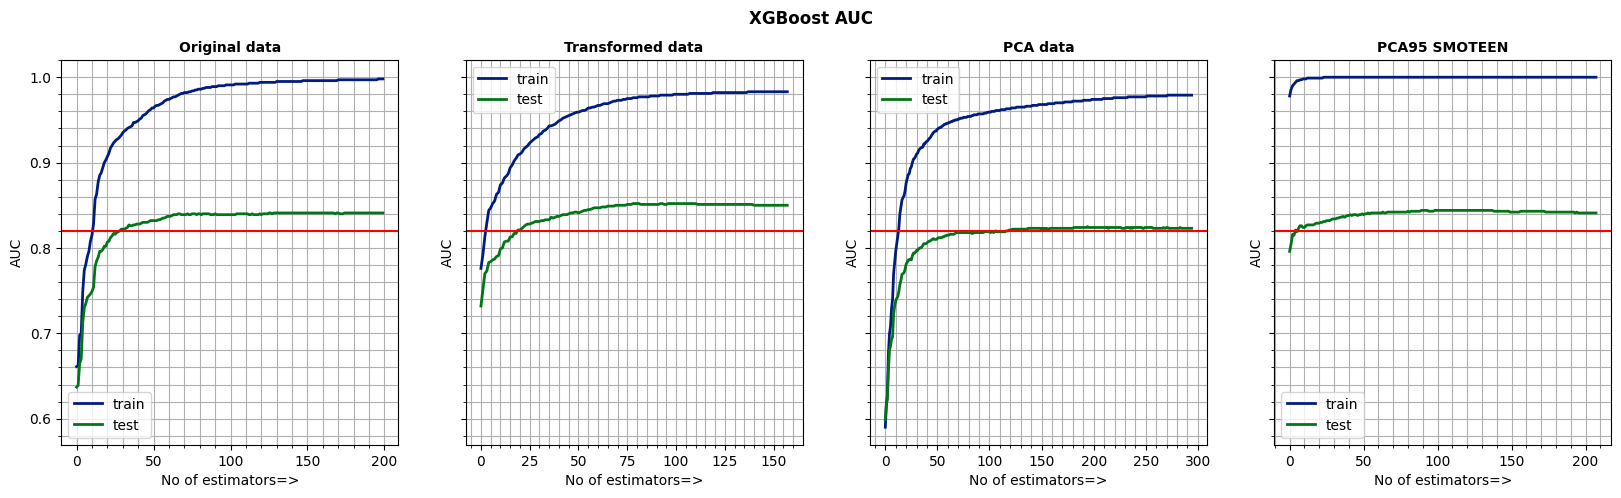

In [44]:
# 19.6

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(), model_pca.evals_result(), model_sme.evals_result() ]
title = ["Original data", 'Transformed data', 'PCA data','PCA95 SMOTEEN']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.82, color = 'r', linestyle = '-')

plt.show();

## Distribution of transformed features:
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

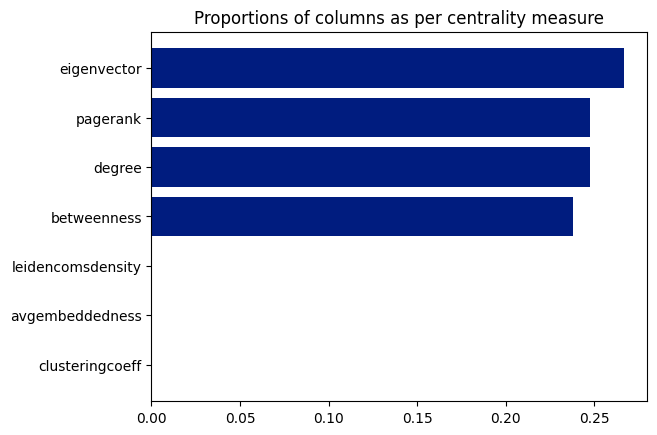

In [46]:
# 20.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# 20.0.1 Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [47]:
# 20.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 179'

'Columns whose impt is 0: 31'

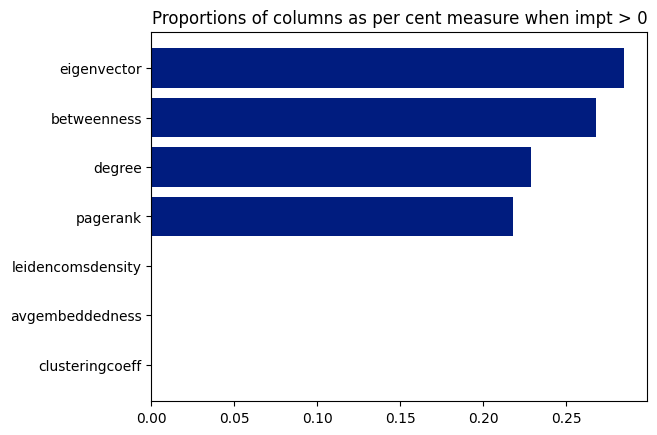

In [48]:
# 20.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [49]:
# 20.3 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [50]:
# 20.4 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 20.4.1 Score of top-five columns:
score[:5]

pr_rolefamily_ck_roledeptname      0.038310
eig_rolefamily_ck_rolerollupOne    0.021097
deg_rolefamily_ck_roledeptname     0.014996
bet_roletitle_ck_roledeptname      0.011388
pr_rolerollupOne_ck_roletitle      0.009951
Name: imp, dtype: float32

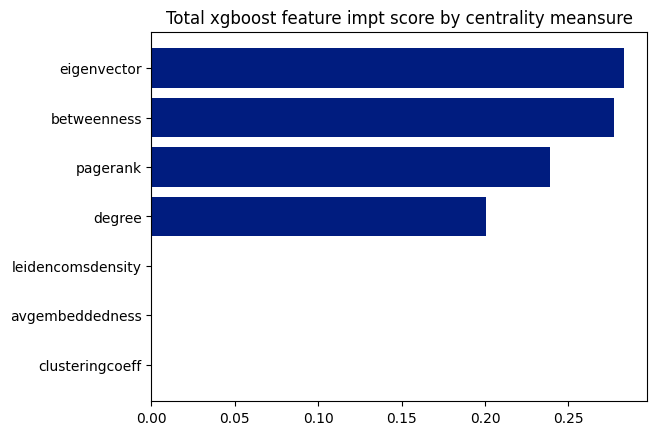

In [51]:
# 20.5 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [52]:
# 21.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [53]:
# 21.1 Path where .gml files are placed:
amazongraphs = Path(amazongraphs)
filelist = sorted(list(amazongraphs.iterdir()))
filelist[5:10]   # mgrid_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_bigraph_rolerolluptwo.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_bigraph_roletitle.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_projected_rolecode.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_projected_roledeptname.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/amazonrevemp/models/mgrid_projected_rolefamily.gml')]

### Read data files from gdrive:

In [54]:
# 21.2 Read original and transformed data:

# Oriinal data:
X_train = pd.read_pickle(amazondata / "X_train.pkl")
X_test = pd.read_pickle(amazondata / "X_test.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

# 21.2.1 Transformed data:
train_trans = pd.read_pickle(amazondata / "train_trans.pkl")
test_trans = pd.read_pickle(amazondata / "test_trans.pkl")

# 21.2.2 Read CatEncodersFamily class instance object:
ct = utils.restorePythonObject( "transformer.pkl", amazondata )

# 21.2.3
cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

In [55]:
# 21.3 check data files:
train_trans.head(2)
test_trans.head(2)
X_train.head(2)
X_test.head(2)
y_train.head(2)
y_test.head(2)

,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,18044,117961,118386,118522,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,0.212401,0.009444,0.016670,0.029940,3.125120e-17,0.003087
1,51345,117961,118052,120417,118702,125047,118704,118705,0.421883,0.024354,...,0.005207,0.004639,0.060084,0.023952,0.010817,0.004082,0.006943,0.005988,-2.292850e-17,0.003087


,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode,deg_mgrid_ck_rolerollupOne,eig_mgrid_ck_rolerollupOne,...,pr_rolecode_ck_roledeptname,bet_rolecode_ck_roledeptname,eig_rolecode_ck_roletitle,deg_rolecode_ck_rolefamilydesc,eig_rolecode_ck_rolefamilydesc,pr_rolecode_ck_rolefamilydesc,bet_rolecode_ck_rolefamilydesc,deg_rolecode_ck_rolefamily,eig_rolecode_ck_rolefamily,pr_rolecode_ck_rolefamily
0,52687,117961,117962,117904,128230,302830,4673,128231,0.421883,0.024354,...,0.005049,0.002170,0.033180,0.005988,5.756833e-18,0.003894,0.00000,0.008982,-1.122321e-17,0.003087
1,3889,117961,118386,121668,118321,117906,290919,118322,0.421883,0.024354,...,0.012837,0.042365,-0.011969,0.083832,2.124007e-01,0.009444,0.01667,0.029940,3.125120e-17,0.003087


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
17277,4675,18044,117961,118386,118522,118321,117906,290919,118322
9292,73495,51345,117961,118052,120417,118702,125047,118704,118705


,resource,mgrid,rolerollupOne,rolerolluptwo,roledeptname,roletitle,rolefamilydesc,rolefamily,rolecode
12953,110357,52687,117961,117962,117904,128230,302830,4673,128231
17348,41269,3889,117961,118386,121668,118321,117906,290919,118322


17277    0
9292     1
Name: action, dtype: int64

12953    0
17348    0
Name: action, dtype: int64

In [56]:
# 21.4 Excludes 'resource'
cat_cols = ['mgrid', 'rolerollupOne', 'rolerolluptwo', 'roledeptname',
           'roletitle', 'rolefamilydesc', 'rolefamily', 'rolecode']

### Display graphs--Bigraphs and Projected

In [57]:
# 21.5 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_projected' in str(i)]

bigraphs = [str(i).split("/")[-1] for i in filelist if 'rolerollupOne_bigraph' in str(i)]
bigraphs = sorted(bigraphs, key=len)
bigraphs[:8]   # bigraph files
print("\n\n====\n")
projected = sorted(projected, key=len)
projected[:8]    # projected graph files

['rolerollupOne_bigraph_mgrid.gml',
 'rolerollupOne_bigraph_rolecode.gml',
 'rolerollupOne_bigraph_roletitle.gml',
 'rolerollupOne_bigraph_rolefamily.gml',
 'rolerollupOne_bigraph_roledeptname.gml',
 'rolerollupOne_bigraph_rolerolluptwo.gml',
 'rolerollupOne_bigraph_rolefamilydesc.gml']



====



['rolerollupOne_projected_mgrid.gml',
 'rolerollupOne_projected_rolecode.gml',
 'rolerollupOne_projected_roletitle.gml',
 'rolerollupOne_projected_rolefamily.gml',
 'rolerollupOne_projected_roledeptname.gml',
 'rolerollupOne_projected_rolerolluptwo.gml',
 'rolerollupOne_projected_rolefamilydesc.gml']

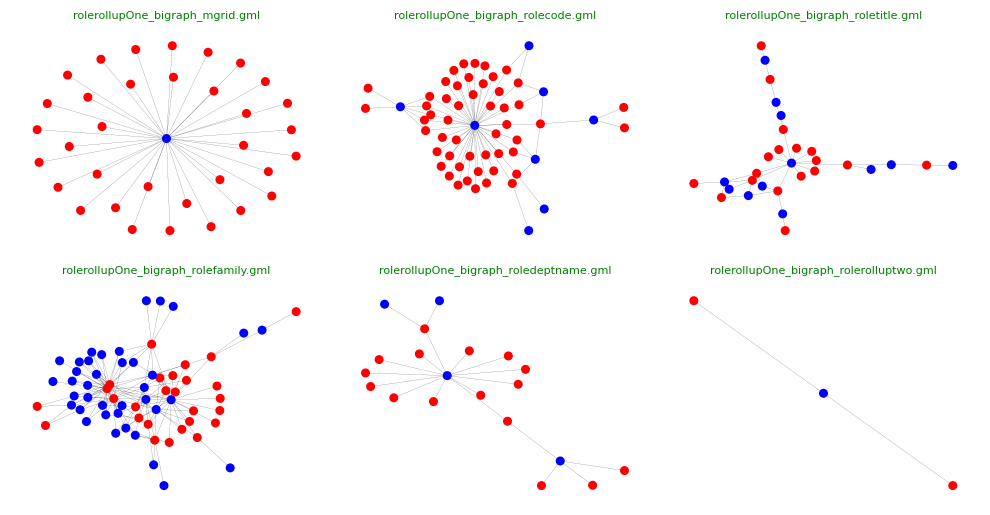

In [58]:
# 21.6 Plot of sample bigraphs:
plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for bi in bigraphs[:6]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    # Only show connedted nodes
    _= utils.plotBipartiteGraph( bi,
                                amazongraphs,
                                 ax = ax,
                                 title = bi,
                                 connected=True,  # Show only connected nodes
                                 takeGraphSample=True # Do not show full graph but a sample of it
                                 )
    plt.tight_layout();

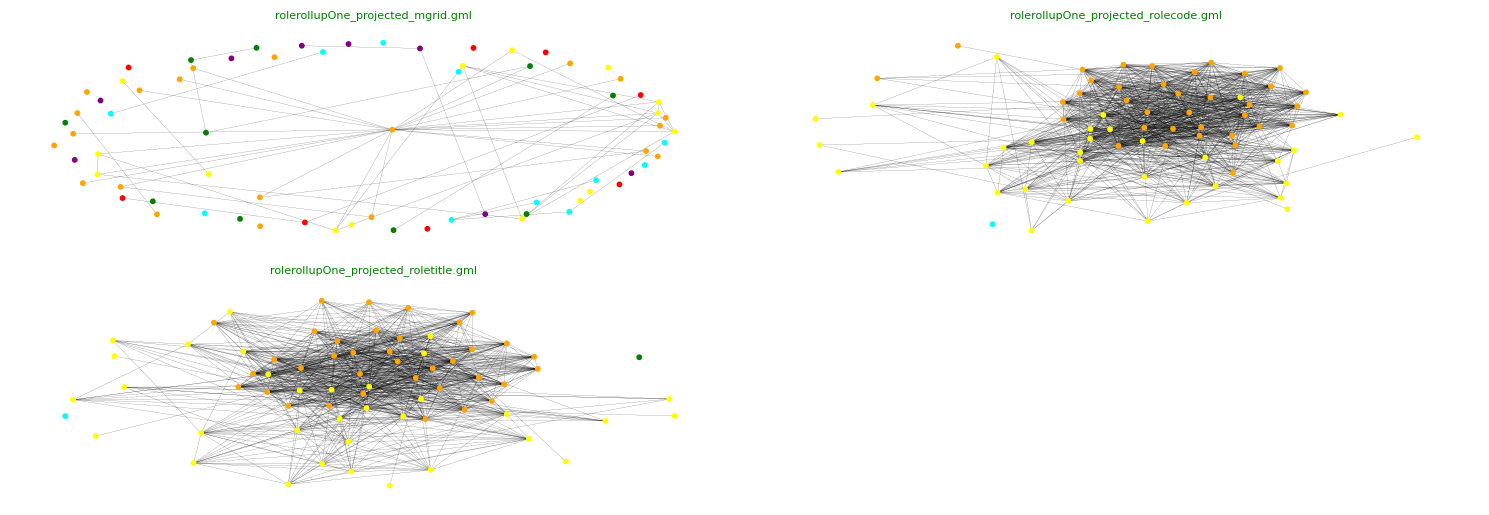

In [59]:
# 21.7 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:3]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   ax = ax,
                                   k = 1.5,   # For spring_layout, to avoid
                                              #  crowding of nodes
                                   withLabels = False,
                                   node_size = 10,
                                   title = prj,
                                   takeGraphSample = True # Do not show full graph
                                                          # but a sample of it
                                   );
    plt.tight_layout();

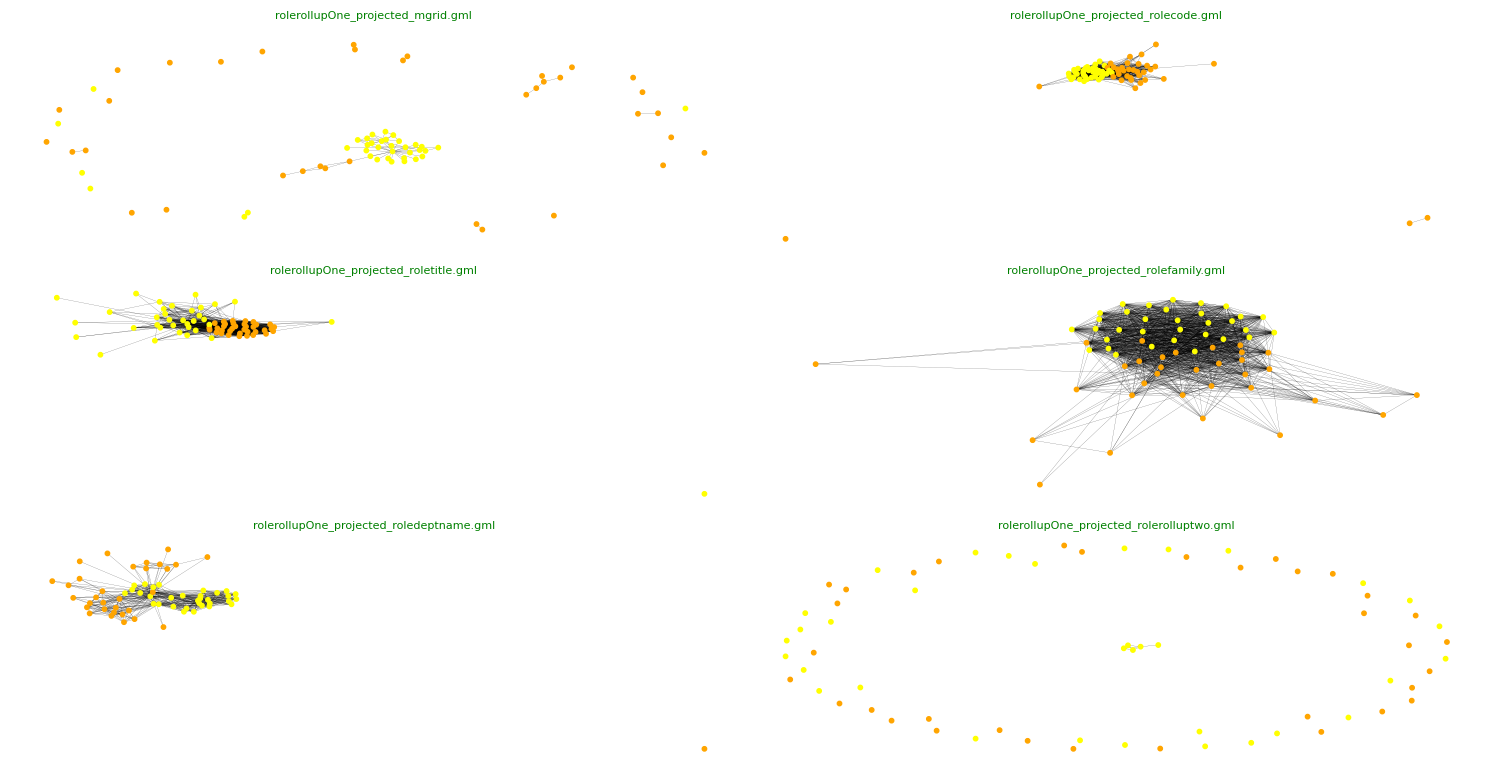

In [60]:
# 21.7.1 Community visualization using
#        kernighan_lin_bisection algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.kernighan_lin_bisection,
                                   node_size = 10,
                                   ax = ax,
                                   withLabels = False,
                                   title = prj,
                                   takeGraphSample = True
                                   );
    plt.tight_layout();

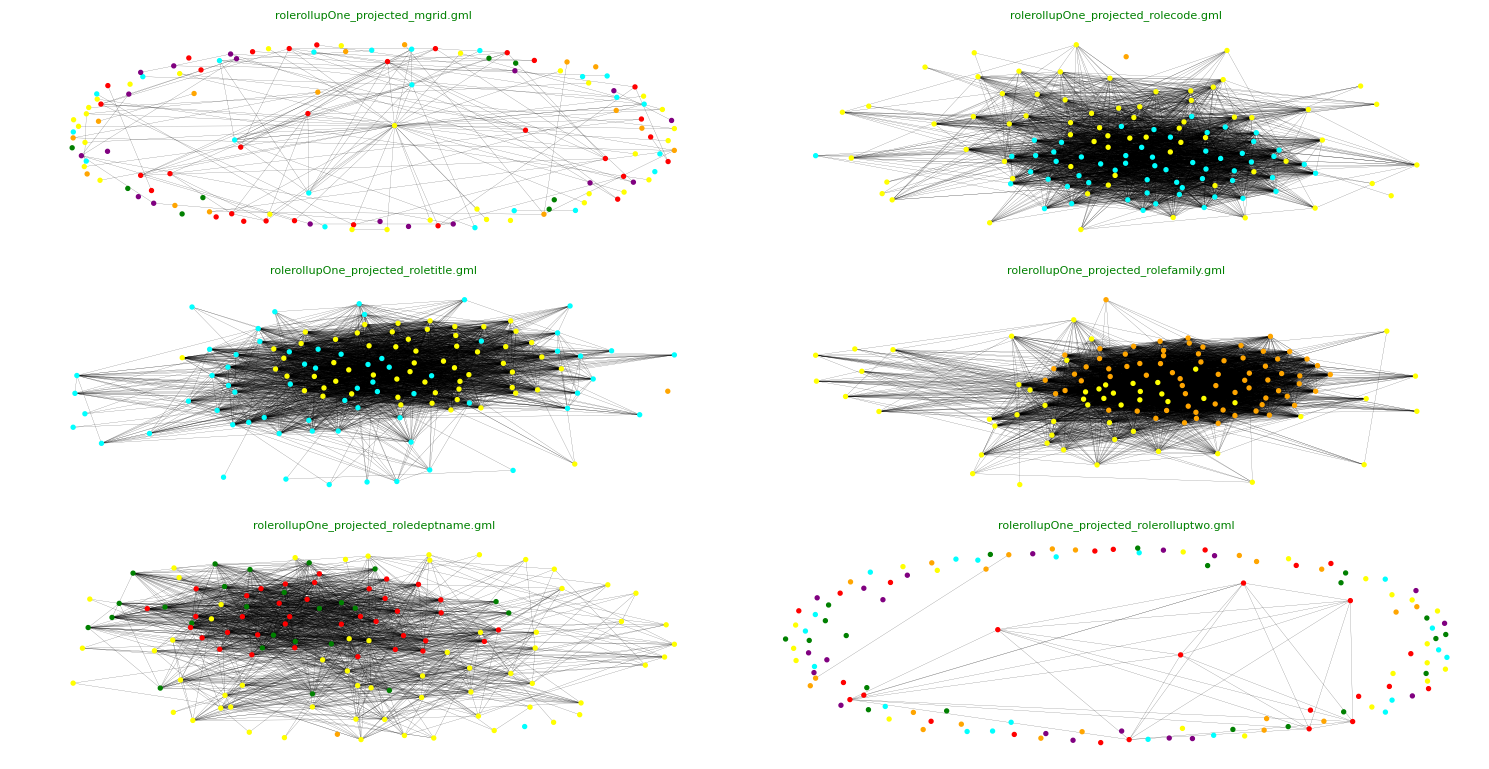

In [61]:
# 21.7.2 Community visualization using
#        louvain_communities algo:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for prj in projected[:6]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    # Only show connected nodes
    _=utils.communityVisualization(prj,
                                   amazongraphs,
                                   algo = nx.community.louvain_communities,
                                   node_size = 8,
                                   k =1.5,  # For spring_layout, to avoid crowding of nodes
                                   ax = ax,
                                   withLabels = False,
                                   title = prj
                                   );
    plt.tight_layout();

## Transform original data to communities data:
Takes time....

In [63]:
# 22.0 Transform each column bin as per the community
#       to which it belongs:

# 22.1 Our transformed discrete cols are:
columnNames = cat_cols

# 22.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 22.3 Graph files are within:
#pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/amazonemp/models"

# 22.4 Perform transformation of both X_train and X_test:
# 22.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []
map_tr = []
map_te = []

# 22.4.2 PErform transformation to community structure
for algo in algolist:
  print("\n..Transforming train data....")
  print("==========================\n")
  map1,df_tr = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_train[cat_cols], algo = algo)
  print("\n==========================")
  print("..Transforming test data....")
  print("==========================\n")
  map2,df_te = utils.transformBinnedDF2Communities(columnNames,amazongraphs,X_test[cat_cols], algo = algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)
  map_tr.append(map1)
  map_te.append(map2)


..Transforming train data....

Reading file:  mgrid_projected_rolerollupOne.gml
Reading file:  mgrid_projected_rolerolluptwo.gml
Reading file:  mgrid_projected_roledeptname.gml
Reading file:  mgrid_projected_roletitle.gml
Reading file:  mgrid_projected_rolefamilydesc.gml
Reading file:  mgrid_projected_rolefamily.gml
Reading file:  mgrid_projected_rolecode.gml
Reading file:  rolerollupOne_projected_mgrid.gml
Reading file:  rolerollupOne_projected_rolerolluptwo.gml
Reading file:  rolerollupOne_projected_roledeptname.gml
Reading file:  rolerollupOne_projected_roletitle.gml
Reading file:  rolerollupOne_projected_rolefamilydesc.gml
Reading file:  rolerollupOne_projected_rolefamily.gml
Reading file:  rolerollupOne_projected_rolecode.gml
Reading file:  rolerolluptwo_projected_mgrid.gml
Reading file:  rolerolluptwo_projected_rolerollupOne.gml
Reading file:  rolerolluptwo_projected_roledeptname.gml
Reading file:  rolerolluptwo_projected_roletitle.gml
Reading file:  rolerolluptwo_projected_role

In [ ]:
# 23.0 Observe few rows of data transformed community wise:
fg_tr[0].shape   # (24576, 52)
print("\n--\n")
fg_te[0].shape   # (8193, 52)
print("\n--\n")
fg_tr[0].head(2)
fg_te[0].head(2)

(24576, 52)


--



(8193, 52)


--



,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17277,0,5,5,0,1,0,0,0,0,0,...,1,2,2,0,0,1,0,0,4,6
9292,0,7,19,2,0,2,2,0,0,0,...,0,1,0,2,2,0,1,1,0,46


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
12953,0.0,11.0,8.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0,1,0,6,1.0,0.0,1.0,0.0,12.0,30.0
17348,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,2,2,0,0.0,1.0,0.0,0.0,4.0,6.0


In [64]:
# 23.1 Remove constant columns from train data:
fg_tr[0] = utils.remConstColumns(fg_tr[0])

# 23.1.1 Keep same columns as above in test data:
fg_te[0] = fg_te[0][fg_tr[0].columns]

Datashape before processing: (24576, 52)
Datashape after processing: (24576, 52)


## Save community transformed data to gdrive
We can analyse it at peace

In [65]:
# 24. Save the list to gdrive:
utils.savePythonObject(fg_tr, "fg_tr.pkl", amazondata)
utils.savePythonObject(fg_te, "fg_te.pkl", amazondata)

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/fg_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/datafiles/fg_te.pkl


## Read back community transformed data from gdrive

In [66]:
# 24.1
fg_tr = utils.restorePythonObject( "fg_tr.pkl", amazondata )
fg_te = utils.restorePythonObject( "fg_te.pkl", amazondata )

In [67]:
# 24.2 Check restoration:
fg_tr[0].head(2)
fg_te[0].head(2)

,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
17277,0,5,5,0,1,0,0,0,0,0,...,1,2,1,0,0,1,0,0,4,6
9292,0,7,19,2,0,2,2,0,0,0,...,0,1,0,2,2,0,1,1,0,44


,mgrid_projected_rolerollupOne.gml,mgrid_projected_rolerolluptwo.gml,mgrid_projected_roledeptname.gml,mgrid_projected_roletitle.gml,mgrid_projected_rolefamilydesc.gml,mgrid_projected_rolefamily.gml,mgrid_projected_rolecode.gml,rolerollupOne_projected_mgrid.gml,rolerollupOne_projected_rolerolluptwo.gml,rolerollupOne_projected_roledeptname.gml,...,rolefamily_projected_rolerollupOne.gml,rolefamily_projected_rolerolluptwo.gml,rolefamily_projected_roledeptname.gml,rolefamily_projected_rolefamilydesc.gml,rolecode_projected_mgrid.gml,rolecode_projected_rolerollupOne.gml,rolecode_projected_rolerolluptwo.gml,rolecode_projected_roledeptname.gml,rolecode_projected_rolefamilydesc.gml,rolecode_projected_rolefamily.gml
12953,0.0,11.0,8.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0,1,0,7,1.0,0.0,1.0,0.0,10.0,32.0
17348,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1,2,1,0,0.0,1.0,0.0,0.0,4.0,6.0


## Check data columns
Our predictors should not have target columns

In [68]:
# 24.3 Check again if target is in predictors!

'target' in list(fg_tr[0].columns)
'target' in list(fg_te[0].columns)
'action' in list(fg_tr[0].columns)
'action' in list(fg_te[0].columns)

False

False

False

False

## xgboost modeling from community indicators:

In [69]:
# 25.0 Modeling with transformed train/test data with community indicators:

# As we repeat the process many times:
# Del the earlier result, if exists:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 250,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = rng,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = y_train
yte = y_test


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 100,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[05:53:49] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[05:53:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=14
[0]	validation_0-auc:0.72178	validation_1-auc:0.67181
[05:53:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=14
[1]	validation_0-auc:0.76280	validation_1-auc:0.72395
[05:53:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=14
[2]	validation_0-auc:0.78079	validation_1-auc:0.73768
[05:53:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=14
[3]	validation_0-auc:0.78653	validation_1-auc:0.73789
[05:53:49] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=14
[4]	validation_0-auc:0.80632	validation_1-auc:0.75138
[05:53:50] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 288 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [70]:
# 25.0.1 Save estimator: model_trans_commu
utils.savePythonObject(model_trans_commu, "model_trans_commu.pkl", amazonestimators )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/estimators/model_trans_commu.pkl


In [71]:
# 25.0.2 Read back saved estimator:
model_trans_commu = utils.restorePythonObject("model_trans_commu.pkl", amazonestimators )

### Learning curve

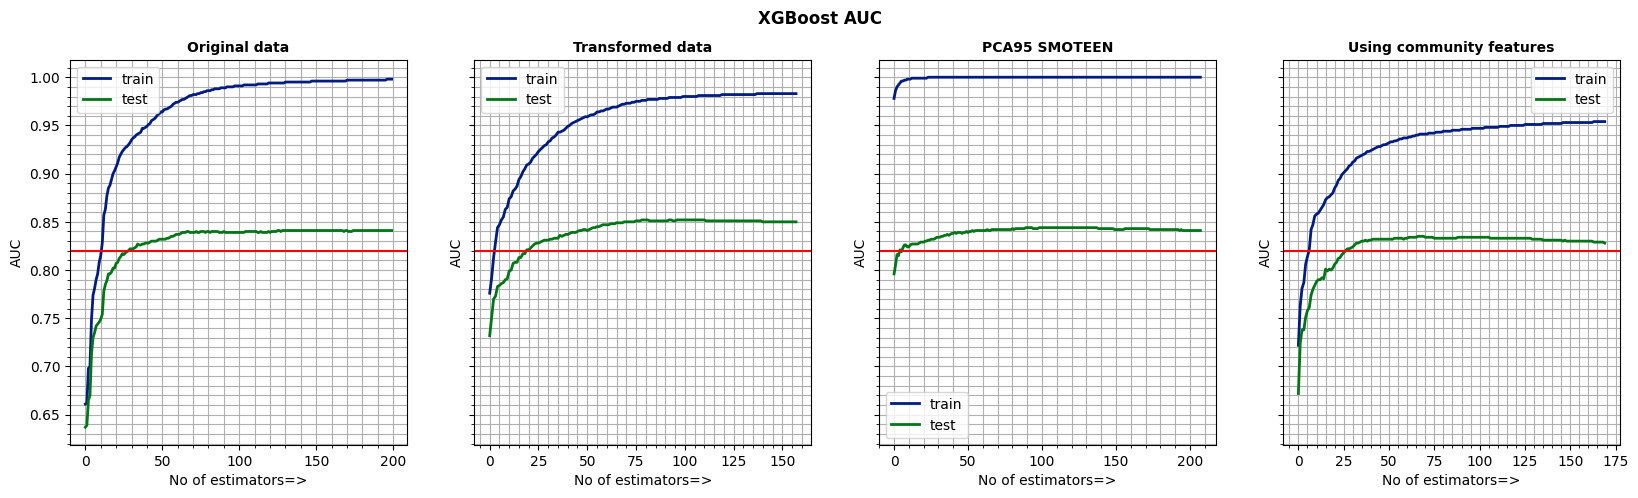

In [75]:
# 25.0.3

plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),  model_sme.evals_result(), model_trans_commu.evals_result() ]
title = ["Original data", 'Transformed data','PCA95 SMOTEEN', 'Using community features']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(4):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=2, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=2, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.82, color = 'r', linestyle = '-')

plt.show();

### Classification report

In [73]:
# 25.2 Classification reports:

pred_orig = model_orig.predict(X_test)
pred_comm = model_trans_commu.predict(test_X)

print("Note that the difference in the two classification reports exist but not to great extent\n")
print(f"Classification report from original data: \n {classification_report(y_test,pred_orig)}")
print("\n==================\n")
print(f"Classification report from community data: \n {classification_report(y_test,pred_comm)}")


Note that the difference in the two classification reports exist but not to great extent

Classification report from original data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.68      0.22      0.34       474

    accuracy                           0.95      8193
   macro avg       0.82      0.61      0.65      8193
weighted avg       0.94      0.95      0.94      8193



Classification report from community data: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.58      0.22      0.32       474

    accuracy                           0.95      8193
   macro avg       0.77      0.61      0.65      8193
weighted avg       0.93      0.95      0.93      8193



## Derive unit-vectors per level per cat column

In [ ]:
##*****************************
## Embedding Projector
## Incidentally f1-score is highest
##*****************************

In [76]:
# 26.0
train_trans = train_trans.reset_index(drop = True)
test_trans = test_trans.reset_index(drop = True)

# 26.1 Reset index
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)


In [77]:
# 26.2 Check for nulls:
train_trans.isnull().sum().sum()
test_trans.isnull().sum().sum()   # 16884/16000

0

16000

In [78]:
# 26.3 Impute test_trans
si = SimpleImputer(strategy = 'median')
si.fit(train_trans)
test_trans[:] = si.transform(test_trans)
# Check
test_trans.isnull().sum().sum()

SimpleImputer(strategy='median')

0

In [79]:
# 26.4 Get target data col. Needed for generation of meta-data file:

test_trans['target'] = y_test
train_trans['target'] =  y_train

In [80]:
# 27.0 Derive unit vectors:

p = Path(amazonunitvecs)
p.mkdir(parents=True, exist_ok=True)

vec_tr,_ = ct.vectorsToTSV(train_trans,
                           take_mean = False,
                           filepath = amazonunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True
                           )

print("\n----test data---\n")

# 26.1 Unit vectors from test data. But not being saved to file:
vec_te,_ = ct.vectorsToTSV(test_trans,
                           take_mean = False,
                           filepath = amazonunitvecs,
                           impute = True,
                           saveVectorsToDisk = False
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/amazonrevemp/unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature

----test data---

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode


## Save unit-vectors files to gdrive
Also save output dictionaries for later use

In [81]:
# 27.2 Save dict to gdrive:

utils.savePythonObject(vec_tr, "vec_tr.pkl", amazonunitvecs)
utils.savePythonObject(vec_te, "vec_te.pkl",amazonunitvecs)

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/unitvec/vec_tr.pkl
Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/unitvec/vec_te.pkl


## Restore unit-vectors files from gdrive

In [82]:
# 27.3 Restore back:
vec_tr = utils.restorePythonObject( "vec_tr.pkl", amazonunitvecs)
vec_te = utils.restorePythonObject("vec_te.pkl",amazonunitvecs)

## Using unit vectors to transform train/test data

In [83]:
# 28.0 USe unit vectors to transform train/test data:

cctr,ccte, vtr,vte = utils.pcaAndConcat(vec_tr, vec_te, n_components = 4)


Performing PCA for mgrid for train data
Performing PCA for mgrid for test data
Performing PCA for rolerollupOne for train data
Performing PCA for rolerollupOne for test data
Performing PCA for rolerolluptwo for train data
Performing PCA for rolerolluptwo for test data
Performing PCA for roledeptname for train data
Performing PCA for roledeptname for test data
Performing PCA for roletitle for train data
Performing PCA for roletitle for test data
Performing PCA for rolefamilydesc for train data
Performing PCA for rolefamilydesc for test data
Performing PCA for rolefamily for train data
Performing PCA for rolefamily for test data
Performing PCA for rolecode for train data
Performing PCA for rolecode for test data
Concatenating train data
Concatenating test data
Done......


In [84]:
# 28.1

cctr.head(3)
ccte.head(3)

,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.649086,1.634371,1.534552,-0.138707,-2.940214,-0.072472,0.013095,-0.071686,-0.188297,2.302686,...,0.008809,0.030232,-3.033227,-0.402983,-0.019771,0.198087,2.328909,-1.462516,-0.143513,0.035751
1,-1.187754,-3.126506,-0.238483,-0.490674,-2.940183,-0.072606,0.013073,-0.071720,1.717482,1.094118,...,-0.643150,1.003094,4.375350,-2.438726,1.040870,-0.880065,-3.072760,-0.921107,0.637974,-0.176515
2,-0.517336,-0.662450,-1.885443,0.220490,-2.940183,-0.072647,0.013082,-0.071533,0.076743,-0.830016,...,0.096613,-0.019330,3.692768,-2.514020,0.604605,-0.707093,-1.151979,-0.921384,0.417708,-0.808073


,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.385669,-3.119521,-0.256565,-0.615995,-2.940183,-0.07266,0.013094,-0.071669,0.076743,-0.830015,...,0.592132,-1.017164,5.941315,-2.294496,0.974841,1.048700,-2.583504,-1.541394,0.881965,-0.533654
1,-1.539986,1.793718,1.444828,-0.057782,-2.940183,-0.07266,0.013094,-0.071669,-0.188318,2.302670,...,0.008797,0.030325,-3.033249,-0.402972,-0.019624,0.198054,2.328907,-1.462528,-0.143534,0.035610
2,-1.697680,1.376243,1.869703,0.081440,-2.940183,-0.07266,0.013094,-0.071669,3.078444,-0.064847,...,0.076519,-0.353129,-3.033249,-0.402972,-0.019624,0.198054,2.041411,-1.528169,-0.032868,0.255656


In [85]:
# 28.2

cctr.shape   #  (24576, 32)
ccte.shape   #  (8193, 32)

(24576, 32)

(8193, 32)

In [86]:
# 28.3 No target here

print(list(cctr.columns[:10]))
print(list(cctr.columns[10:20]))
print(list(cctr.columns[20:30]))
print(list(cctr.columns[30:]))


['pcmgrid0', 'pcmgrid1', 'pcmgrid2', 'pcmgrid3', 'pcrolerollupOne0', 'pcrolerollupOne1', 'pcrolerollupOne2', 'pcrolerollupOne3', 'pcrolerolluptwo0', 'pcrolerolluptwo1']
['pcrolerolluptwo2', 'pcrolerolluptwo3', 'pcroledeptname0', 'pcroledeptname1', 'pcroledeptname2', 'pcroledeptname3', 'pcroletitle0', 'pcroletitle1', 'pcroletitle2', 'pcroletitle3']
['pcrolefamilydesc0', 'pcrolefamilydesc1', 'pcrolefamilydesc2', 'pcrolefamilydesc3', 'pcrolefamily0', 'pcrolefamily1', 'pcrolefamily2', 'pcrolefamily3', 'pcrolecode0', 'pcrolecode1']
['pcrolecode2', 'pcrolecode3']


### Save unitvectors transformed train/test

In [87]:
# 28.4 Save cctr/ccte to gdrive
cctr.to_pickle(amazondata / "cctr.pkl")
ccte.to_pickle(amazondata / "ccte.pkl")

### Readback unitvectors transformed train/test

In [88]:
# 28.5 Read back cctr/ccte
cctr = pd.read_pickle(amazondata / "cctr.pkl")
ccte = pd.read_pickle(amazondata / "ccte.pkl")
y_train = pd.read_pickle(amazondata / "y_train.pkl")
y_test = pd.read_pickle(amazondata / "y_test.pkl")

# 28.5.1 Check
cctr.head(2)
ccte.head(2)
cctr.shape # (24576, 32)
ccte.shape # (8193, 32)

,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.649086,1.634371,1.534552,-0.138707,-2.940214,-0.072472,0.013095,-0.071686,-0.188297,2.302686,...,0.008809,0.030232,-3.033227,-0.402983,-0.019771,0.198087,2.328909,-1.462516,-0.143513,0.035751
1,-1.187754,-3.126506,-0.238483,-0.490674,-2.940183,-0.072606,0.013073,-0.071720,1.717482,1.094118,...,-0.643150,1.003094,4.375350,-2.438726,1.040870,-0.880065,-3.072760,-0.921107,0.637974,-0.176515


,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolefamilydesc2,pcrolefamilydesc3,pcrolefamily0,pcrolefamily1,pcrolefamily2,pcrolefamily3,pcrolecode0,pcrolecode1,pcrolecode2,pcrolecode3
0,-1.385669,-3.119521,-0.256565,-0.615995,-2.940183,-0.07266,0.013094,-0.071669,0.076743,-0.830015,...,0.592132,-1.017164,5.941315,-2.294496,0.974841,1.048700,-2.583504,-1.541394,0.881965,-0.533654
1,-1.539986,1.793718,1.444828,-0.057782,-2.940183,-0.07266,0.013094,-0.071669,-0.188318,2.302670,...,0.008797,0.030325,-3.033249,-0.402972,-0.019624,0.198054,2.328907,-1.462528,-0.143534,0.035610


(24576, 32)

(8193, 32)

## xgboost modeling

In [89]:
# 28.6 Perform xgboost modeling using the above train/test data:

model_vec = xgb.XGBClassifier( n_estimators= 250,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = rng,
                              reg_lambda = 1.5,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    cctr
test_X =  ccte
ytrain =  y_train
ytest = y_test


model_vec.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[06:05:59] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.74729	validation_1-auc:0.71600
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.77514	validation_1-auc:0.74151
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.78300	validation_1-auc:0.74881
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 272 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.78192	validation_1-auc:0.74976
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.80952	validation_1-auc:0.76497
[06:06:00] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 324 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [90]:
# 28.4.1 Save estimator: model_vec
utils.savePythonObject(model_vec, "model_vec.pkl", amazonestimators )

Object saved to: /gdrive/MyDrive/Colab_data_files/amazonrevemp/estimators/model_vec.pkl


In [91]:
# 28.4.2 Read back saved estimator:
model_vec = utils.restorePythonObject("model_vec.pkl", amazonestimators )

In [92]:
# 28.5 Best scores:

model_vec.best_score   # 0.84985279350/0.85893922771/0.856534481
print("\n")
model_vec.best_iteration  # 70/71/74


0.8565344814674514

74

#### Classification report

In [93]:
# 28.6 Classification report:

pred_vec = model_vec.predict(test_X)
print(classification_report(ytest,pred_vec))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.67      0.31      0.42       474

    accuracy                           0.95      8193
   macro avg       0.81      0.65      0.70      8193
weighted avg       0.94      0.95      0.94      8193



#### Learning curve

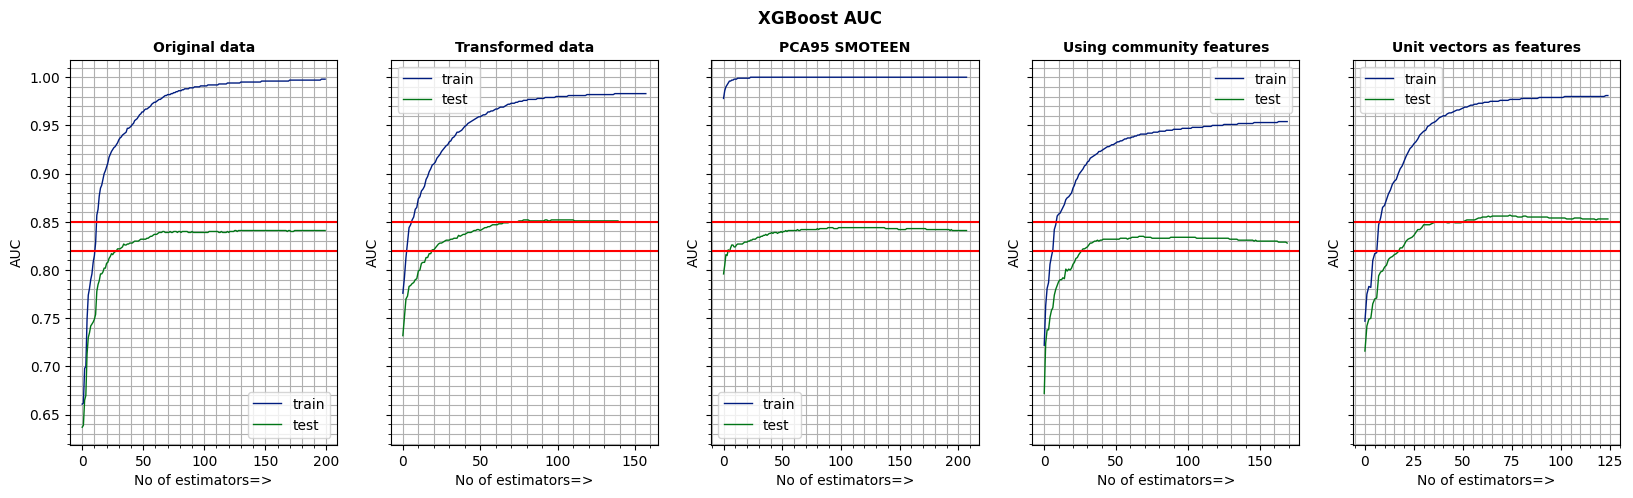

In [106]:
# 28.6.1
plt.style.use("default")
plt.style.use('seaborn-v0_8-dark-palette')
# Ref: https://stackoverflow.com/a/60366515

fig, ax = plt.subplots(1,5, figsize = (20,5), sharey = True);
results = [model_orig.evals_result(),model_trans.evals_result(),  model_sme.evals_result(), model_trans_commu.evals_result(), model_vec.evals_result() ]
title = ["Original data", 'Transformed data','PCA95 SMOTEEN', 'Using community features', 'Unit vectors as features']
fig.suptitle("XGBoost AUC", fontweight = "bold")
for i in range(5):
    epochs = len(results[i]['validation_0']['auc'])
    x_axis = range(0,epochs)
    ax[i].plot(x_axis, np.round(results[i]['validation_0']['auc'],3),linewidth=1, label='train');
    ax[i].plot(x_axis, np.round(results[i]['validation_1']['auc'],3), linewidth=1, label='test');
    ax[i].legend();
    ax[i].grid(visible = True, which = 'both');
    ax[i].minorticks_on();
    ax[i].set_ylabel('AUC');
    ax[i].set_xlabel("No of estimators=>")
    ax[i].set_title(title[i], fontsize = 10, fontweight = "bold");
    ax[i].axhline(y = 0.82, color = 'r', linestyle = '-')
    ax[i].axhline(y = 0.85, color = 'r', linestyle = '-')

plt.show();

## Mean unit vectors for embedding
These may help to find relationships among levels of a feature

In [96]:
# 29.0
train_trans['target'] = y_train

vec_trx,_ = ct.vectorsToTSV(train_trans,
                           take_mean = True,
                           filepath = amazonunitvecs,   # Folder where csv files will be saved
                           saveVectorsToDisk = True,
                           fnamesuffix = "_avg"
                           )

Checking if vectors exist for all cat cols...
May take time...
Checked for mgrid
Checked for rolerollupOne
Checked for rolerolluptwo
Checked for roledeptname
Checked for roletitle
Checked for rolefamilydesc
Checked for rolefamily
Checked for rolecode
Saved files are named as '<catColname>.tsv' and '<catColname_meta>.tsv'
You will find them in folder: '/gdrive/MyDrive/Colab_data_files/amazonrevemp/unitvec'
Load these file-pairs in tensorflow's 'Embedding Projector'
It helps in visualizing interrelationships among levels of a categorical feature


## Feature Engineering with clustering

In [97]:
# 30.0 Create clustering features from unitvector dataframes:

n_components = 4 # No of components while performing PCA of every feature
fe_tr,fe_te = utils.featureEngKmeans(cctr,
                                     ccte,
                                     n_clusters = 25,  # No of clusters per feature
                                     step_size = n_components,
                                     km=True,  # Only perform KMeans
                                     gmm=False  # No Gaussian Mixture modeling
                                     )

Current index:  0
Current index:  4
Current index:  8
Current index:  12
Current index:  16
Current index:  20
Current index:  24
Current index:  28


In [98]:
# 30.1 Output is orig dataframe + clusters
fe_tr.head(3)
fe_te.head(3)

,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolecode2,pcrolecode3,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7
0,-1.649086,1.634371,1.534552,-0.138707,-2.940214,-0.072472,0.013095,-0.071686,-0.188297,2.302686,...,-0.143513,0.035751,18,0,9,18,13,2,1,11
1,-1.187754,-3.126506,-0.238483,-0.490674,-2.940183,-0.072606,0.013073,-0.071720,1.717482,1.094118,...,0.637974,-0.176515,1,0,18,3,8,13,4,1
2,-0.517336,-0.662450,-1.885443,0.220490,-2.940183,-0.072647,0.013082,-0.071533,0.076743,-0.830016,...,0.417708,-0.808073,9,0,19,0,18,21,4,3


,pcmgrid0,pcmgrid1,pcmgrid2,pcmgrid3,pcrolerollupOne0,pcrolerollupOne1,pcrolerollupOne2,pcrolerollupOne3,pcrolerolluptwo0,pcrolerolluptwo1,...,pcrolecode2,pcrolecode3,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7
0,-1.385669,-3.119521,-0.256565,-0.615995,-2.940183,-0.07266,0.013094,-0.071669,0.076743,-0.830015,...,0.881965,-0.533654,1,0,19,24,4,12,18,1
1,-1.539986,1.793718,1.444828,-0.057782,-2.940183,-0.07266,0.013094,-0.071669,-0.188318,2.302670,...,-0.143534,0.035610,18,0,9,14,13,2,1,11
2,-1.697680,1.376243,1.869703,0.081440,-2.940183,-0.07266,0.013094,-0.071669,3.078444,-0.064847,...,-0.032868,0.255656,3,0,1,11,6,1,1,11


In [99]:
# 30.2 Have a look at clusters created:

colNames = [i for i in fe_tr.columns if "clu" in i]
fe_tr[colNames].head(3)
fe_te[colNames].head(3)


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7
0,18,0,9,18,13,2,1,11
1,1,0,18,3,8,13,4,1
2,9,0,19,0,18,21,4,3


,clu0,clu1,clu2,clu3,clu4,clu5,clu6,clu7
0,1,0,19,24,4,12,18,1
1,18,0,9,14,13,2,1,11
2,3,0,1,11,6,1,1,11


In [100]:
# 30.3 Perform xgboost modeling using only the above clustered data:

model_fe = xgb.XGBClassifier( n_estimators= 200,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.9,
                              random_state = None,
                              reg_lambda = 1.5,
                           )

tr_X =   fe_tr[colNames]
test_X =  fe_te[colNames]
ytrain =  y_train
ytest = y_test


model_fe.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[06:12:42] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[06:12:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.64628	validation_1-auc:0.61943
[06:12:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[1]	validation_0-auc:0.65791	validation_1-auc:0.62930
[06:12:42] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.68785	validation_1-auc:0.65639
[06:12:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=11
[3]	validation_0-auc:0.70337	validation_1-auc:0.67477
[06:12:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation_0-auc:0.72913	validation_1-auc:0.69048
[06:12:43] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 214 extra nodes, 0 pruned nod

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [101]:
# 30.4 Best score
model_fe.best_score  # 0.82913688235


0.8291368823599831

In [103]:
# 30.5 Classification report:

pred_fe = model_fe.predict(test_X)
print(classification_report(y_test,pred_fe))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7719
           1       0.62      0.22      0.33       474

    accuracy                           0.95      8193
   macro avg       0.79      0.61      0.65      8193
weighted avg       0.93      0.95      0.94      8193



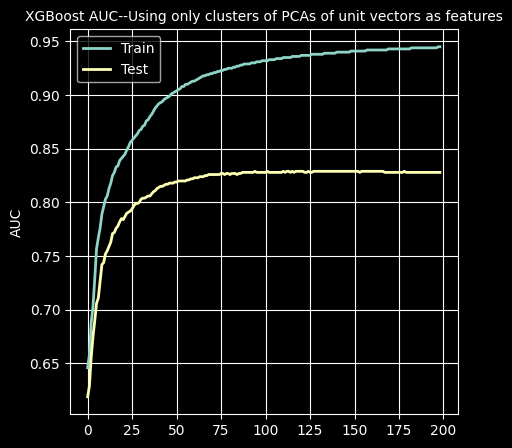

In [102]:
# 30.6 Learning curve

# Ref: https://stackoverflow.com/a/60366515
plt.style.use("dark_background")
plt.figure(figsize = (5,5));
results = model_fe.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
plt.plot(x_axis, np.round(results['validation_0']['auc'],3),linewidth=2, label='Train');
plt.plot(x_axis, np.round(results['validation_1']['auc'],3), linewidth=2, label='Test');
plt.legend();
plt.grid()
plt.ylabel('AUC');
plt.title("XGBoost AUC--Using only clusters of PCAs of unit vectors as features", fontsize = 10);


In [ ]:
############ DONE ######################

## Some rough work below

In [ ]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours, EditedNearestNeighbours, NeighbourhoodCleaningRule,OneSidedSelection,InstanceHardnessThreshold
from imblearn.combine import SMOTEENN

In [ ]:
#ncr = NeighbourhoodCleaningRule(n_neighbors = 3)
#oss = OneSidedSelection()
inst = InstanceHardnessThreshold()
#enn = EditedNearestNeighbours()
#renn = RepeatedEditedNearestNeighbours()
#smt  = SMOTEENN()
#X_res, y_res = ncr.fit_resample(tr_mod, y_train)
X_res, y_res = inst.fit_resample(tr_mod, y_train)

In [ ]:
X_res.shape

(14802, 40)

In [ ]:
# 28.4 Perform xgboost modeling using the above train/test data:

model_km = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = 890,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  te_mod
ytrain =  y_res
ytest = y_test


model_km.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

In [ ]:
model_km.best_score

0.8454662531984478

In [ ]:
# 28.6 Classification report:

pred_km = model_km.predict(test_X)
print(classification_report(y_test,pred_km))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7719
           1       0.28      0.69      0.39       474

    accuracy                           0.88      8193
   macro avg       0.63      0.79      0.66      8193
weighted avg       0.94      0.88      0.90      8193



In [ ]:
# Read back the above saved data:
#datafolder = "/gdrive/MyDrive/Colab_data_files/amazonemp/datafiles/data/"

pca_train_full = pd.read_pickle(amazondata + "pca_train_full.pkl")
pca_test_full = pd.read_pickle(amazondata + "pca_test_full.pkl")

# Check
pca_train_full.shape  # (24576, 39)
pca_test_full.shape   # (8193, 39)
pca_train_full.head(2)

(24576, 39)

(8193, 39)

,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38
0,-1.177204,0.985659,0.844031,1.546484,-1.287232,0.647936,0.645013,-1.601013,-1.056423,-2.041391,...,0.606227,2.357795,0.654308,0.685968,-1.510676,0.854635,-0.616610,1.107696,1.578789,-1.012790
1,0.411428,-1.434911,-0.506739,-1.608989,-0.095674,1.012032,-0.302223,-0.386375,0.404760,-0.906226,...,0.812353,-1.283172,-0.201607,-0.304102,-0.937721,0.591023,-0.238826,-0.146825,-1.452722,0.867205


In [ ]:
from imblearn.under_sampling import OneSidedSelection, TomekLinks
#from imblearn.under_sampling import NeighbourhoodCleaningRule,OneSidedSelection,InstanceHardnessThreshold
#from imblearn.combine import SMOTEENN

In [ ]:
rng = 654

In [ ]:
#ihd = InstanceHardnessThreshold()
ihd = OneSidedSelection(random_state = rng, n_neighbors = 3)   # BEST AUC SO FAR
#tc = TomekLinks()
#inst = InstanceHardnessThreshold()
#enn = EditedNearestNeighbours()
#renn = RepeatedEditedNearestNeighbours()
#smt  = SMOTEENN()
X_res, y_res = ihd.fit_resample(pca_train_full, y_train)  # BEST RESULTS
#X_res, y_res = tc.fit_resample(pca_train_full, y_train)
#X_res, y_res = inst.fit_resample(tr_mod, y_train)

In [ ]:
# 28.4 Perform xgboost modeling using the above train/test data:

model_ncr = xgb.XGBClassifier( n_estimators= 450,
                              verbosity = 3,
                              eta = 0.06,
                              max_depth = 13,
                              subsample = 0.8,
                              random_state = rng,
                           )

## NOTE THIS IS WITHOT resource column
tr_X =    X_res
test_X =  pca_test_full
ytrain =  y_res
ytest = y_test


model_ncr.fit(tr_X, ytrain.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytrain.values),(test_X, ytest.values)],
          eval_metric = ['auc']
          )

[09:42:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[09:42:14] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=13
[0]	validation_0-auc:0.75834	validation_1-auc:0.69100
[09:42:15] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=13
[1]	validation_0-auc:0.80265	validation_1-auc:0.72722
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=13
[2]	validation_0-auc:0.83207	validation_1-auc:0.75396
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=13
[3]	validation_0-auc:0.85296	validation_1-auc:0.76157
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=13
[4]	validation_0-auc:0.86153	validation_1-auc:0.75832
[09:42:16] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 404 extra nodes, 0 pruned n

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=13,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [ ]:
model_ncr.best_score

0.8535602871537873

In [ ]:
# 28.6 Classification report:

pred_ncr = model_ncr.predict(test_X)
print(classification_report(y_test,pred_ncr))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7719
           1       0.63      0.35      0.45       474

    accuracy                           0.95      8193
   macro avg       0.80      0.67      0.71      8193
weighted avg       0.94      0.95      0.94      8193



In [ ]:
for i in X_train.columns:
  print(i,X_train[i].nunique())

resource 6467
mgrid 3995
rolerollupOne 126
rolerolluptwo 172
roledeptname 442
roletitle 335
rolefamilydesc 2171
rolefamily 67
rolecode 335
